In [1]:

import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
from matplotlib import pyplot as plt
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde
from BlockSync_current import BlockSync
import UtilityFunctions_newOE as uf
from scipy import signal
import bokeh
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs


def bokeh_plotter(data_list, x_axis_list=None, label_list=None,
                  plot_name='default',
                  x_axis_label='X', y_axis_label='Y',
                  peaks=None, peaks_list=False, export_path=False):
    """Generates an interactive Bokeh plot for the given data vector.
    Args:
        data_list (list or array): The data to be plotted.
        label_list (list of str): The labels of the data vectors
        plot_name (str, optional): The title of the plot. Defaults to 'default'.
        x_axis (str, optional): The label for the x-axis. Defaults to 'X'.
        y_axis (str, optional): The label for the y-axis. Defaults to 'Y'.
        peaks (list or array, optional): Indices of peaks to highlight on the plot. Defaults to None.
        export_path (False or str): when set to str, will output the resulting html fig
    """
    color_cycle = cycle(bokeh.palettes.Category10_10)
    fig = bokeh.plotting.figure(title=f'bokeh explorer: {plot_name}',
                                x_axis_label=x_axis_label,
                                y_axis_label=y_axis_label,
                                plot_width=1500,
                                plot_height=700)

    for i, data_vector in enumerate(data_list):

        color = next(color_cycle)

        if x_axis_list is None:
            x_axis = range(len(data_vector))
        elif len(x_axis_list) == len(data_list):
            print('x_axis manually set')
            x_axis = x_axis_list[i]
        else:
            raise Exception('problem with x_axis_list input - should be either None, or a list with the same length as data_list')
        if label_list is None:
            fig.line(x_axis, data_vector, line_color=color, legend_label=f"Line {i+1}")
        elif len(label_list) == len(data_list):
            fig.line(range(len(data_vector)), data_vector, line_color=color, legend_label=f"{label_list[i]}")
        if peaks is not None and peaks_list is True:
            fig.circle(peaks[i], data_vector[peaks[i]], size=10, color=color)

    if peaks is not None and peaks_list is False:
        fig.circle(peaks, data_vector[peaks], size=10, color='red')

    if export_path is not False:
        print(f'exporting to {export_path}')
        bokeh.io.output.output_file(filename=str(export_path / f'{plot_name}.html'), title=f'{plot_name}')
    bokeh.plotting.show(fig)


def load_eye_data_2d_w_rotation_matrix(block):
    """
    This function checks if the eye dataframes and rotation dict object exist, then imports them
    :param block: The current blocksync class with verifiec re/le dfs
    :return: None
    """
    try:
        block.left_eye_data = pd.read_csv(block.analysis_path / 'left_eye_data.csv', index_col=0, engine='python')
        block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data.csv', index_col=0, engine='python')
    except FileNotFoundError:
        print('eye_data files not found, run the pipeline!')
        return

    try:
        with open(block.analysis_path / 'rotate_eye_data_params.pkl', 'rb') as file:
            rotation_dict = pickle.load(file)
            block.left_rotation_matrix = rotation_dict['left_rotation_matrix']
            block.right_rotation_matrix = rotation_dict['right_rotation_matrix']
            block.left_rotation_angle = rotation_dict['left_rotation_angle']
            block.right_rotation_angle = rotation_dict['right_rotation_angle']
    except FileNotFoundError:
        print('No rotation matrix file, create it')


def create_saccade_events_df(eye_data_df, speed_threshold, bokeh_verify_threshold=False, magnitude_calib=1, speed_profile=True):
    """
    Detects saccade events in eye tracking data and computes relevant metrics.

    Parameters:
    - eye_data_df (pd.DataFrame): Input DataFrame containing eye tracking data.
    - speed_threshold (float): Threshold for saccade detection based on speed.

    Returns:
    - df (pd.DataFrame): Modified input DataFrame with added columns for speed and saccade detection.
    - saccade_events_df (pd.DataFrame): DataFrame containing information about detected saccade events.

    Steps:
    1. Calculate speed components ('speed_x', 'speed_y') based on differences in 'center_x' and 'center_y'.
    2. Compute the magnitude of the velocity vector ('speed_r').
    3. Create a binary column ('is_saccade') indicating saccade events based on the speed threshold.
    4. Determine saccade onset and offset indices and timestamps.
    5. Create a DataFrame ('saccade_events_df') with columns:
        - 'saccade_start_ind': Indices of saccade onset.
        - 'saccade_start_timestamp': Timestamps corresponding to saccade onset.
        - 'saccade_end_ind': Indices of saccade offset.
        - 'saccade_end_timestamp': Timestamps corresponding to saccade offset.
        - 'length': Duration of each saccade event.
    6. Calculate distance traveled and angles for each saccade event.
    7. Append additional columns to 'saccade_events_df':
        - 'magnitude': Magnitude of the distance traveled during each saccade.
        - 'angle': Angle of the saccade vector in degrees.
        - 'initial_x', 'initial_y': Initial coordinates of the saccade.
        - 'end_x', 'end_y': End coordinates of the saccade.

    Note: The original 'eye_data_df' is not modified; modified data is returned as 'df'.
    """
    df = eye_data_df
    df['speed_x'] = df['center_x'].diff()  # Difference between consecutive 'center_x' values
    df['speed_y'] = df['center_y'].diff()  # Difference between consecutive 'center_y' values

    # Step 2: Calculate magnitude of the velocity vector (R vector speed)
    df['speed_r'] = (df['speed_x']**2 + df['speed_y']**2)**0.5

    # Create a column for saccade detection
    df['is_saccade'] = df['speed_r'] > speed_threshold

    # create a saccade_on_off indicator where 1 is rising edge and -1 is falling edge by subtracting a shifted binary mask
    saccade_on_off = df.is_saccade.astype(int) - df.is_saccade.shift(periods=1,fill_value=False).astype(int)
    saccade_on_inds = np.where(saccade_on_off == 1)[0] - 1 # notice the manual shift here, chosen to include the first (sometimes slower) eye frame, just before saccade threshold crossing
    saccade_on_ms = df['ms_axis'].iloc[saccade_on_inds]
    saccade_on_timestamps = df['OE_timestamp'].iloc[saccade_on_inds]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]
    saccade_off_timestamps = df['OE_timestamp'].iloc[saccade_off_inds]
    saccade_off_ms = df['ms_axis'].iloc[saccade_off_inds]

    saccade_dict = {'saccade_start_ind' :  saccade_on_inds ,
                    'saccade_start_timestamp': saccade_on_timestamps.values,
                    'saccade_end_ind':      saccade_off_inds,
                    'saccade_end_timestamp':saccade_off_timestamps.values,
                    'saccade_on_ms': saccade_on_ms.values,
                    'saccade_off_ms': saccade_off_ms.values}

    saccade_events_df = pd.DataFrame.from_dict(saccade_dict)
    saccade_events_df['length'] = saccade_events_df['saccade_end_ind'] - saccade_events_df['saccade_start_ind']
    # Drop columns used for intermediate steps
    df = df.drop(['is_saccade'], axis=1)

    distances = []
    angles = []
    speed_list = []
    speed_list_calib = []
    diameter_list = []
    for index, row in tqdm.tqdm(saccade_events_df.iterrows()):
        saccade_samples = df.loc[(df['OE_timestamp'] >= row['saccade_start_timestamp']) &
                                 (df['OE_timestamp'] <= row['saccade_end_timestamp'])]
        distance_traveled = saccade_samples['speed_r'].sum()
        if speed_profile:
            saccade_speed_profile = saccade_samples['speed_r'].values
            saccade_calib_speed_profile = saccade_samples['speed_r'].values * magnitude_calib
            speed_list.append(saccade_speed_profile)
            speed_list_calib.append(saccade_calib_speed_profile)
        saccade_diameter_profile = saccade_samples['pupil_diameter'].values
        diameter_list.append(saccade_diameter_profile)
        # Calculate angle from initial position to endpoint
        initial_position = saccade_samples.iloc[0][['center_x', 'center_y']]
        endpoint = saccade_samples.iloc[-1][['center_x', 'center_y']]
        overall_angle = np.arctan2(endpoint['center_y'] - initial_position['center_y'],
                           endpoint['center_x'] - initial_position['center_x'])

        angles.append(overall_angle)
        distances.append(distance_traveled)



    saccade_events_df['magnitude_raw'] = np.array(distances)
    saccade_events_df['magnitude'] = np.array(distances) * magnitude_calib
    saccade_events_df['angle'] = np.where(np.isnan(angles), angles, np.rad2deg(angles) % 360) # Convert radians to degrees and ensure result is in [0, 360)
    start_ts = saccade_events_df['saccade_start_timestamp'].values
    end_ts = saccade_events_df['saccade_end_timestamp'].values
    saccade_start_df = df[df['OE_timestamp'].isin(start_ts)]
    saccade_end_df = df[df['OE_timestamp'].isin(end_ts)]
    start_x_coord = saccade_start_df['center_x']
    start_y_coord = saccade_start_df['center_y']
    end_x_coord = saccade_end_df['center_x']
    end_y_coord = saccade_end_df['center_y']
    saccade_events_df['initial_x'] = start_x_coord.values
    saccade_events_df['initial_y'] = start_y_coord.values
    saccade_events_df['end_x'] = end_x_coord.values
    saccade_events_df['end_y'] = end_y_coord.values
    saccade_events_df['calib_dx'] = (saccade_events_df['end_x'].values - saccade_events_df['initial_x'].values) * magnitude_calib
    saccade_events_df['calib_dy'] = (saccade_events_df['end_y'].values - saccade_events_df['initial_y'].values) * magnitude_calib
    if speed_profile:
        saccade_events_df['speed_profile'] = speed_list
        saccade_events_df['speed_profile_calib'] = speed_list_calib
    saccade_events_df['diameter_profile'] = diameter_list
    if bokeh_verify_threshold:
        bokeh_plotter(data_list=[df.speed_r], label_list=['Pupil Velocity'], peaks=saccade_on_inds)

    return df, saccade_events_df


In [2]:

# create a multi-animal block_collection:

def create_block_collections(animals, block_lists, experiment_path, bad_blocks=None):
    """
    Create block collections and a block dictionary from multiple animals and their respective block lists.

    Parameters:
    - animals: list of str, names of the animals.
    - block_lists: list of lists of int, block numbers corresponding to each animal.
    - experiment_path: pathlib.Path, path to the experiment directory.
    - bad_blocks: list of int, blocks to exclude. Default is an empty list.

    Returns:
    - block_collection: list of BlockSync objects for all specified blocks.
    - block_dict: dictionary where keys are block numbers as strings and values are BlockSync objects.
    """
    import UtilityFunctions_newOE as uf

    if bad_blocks is None:
        bad_blocks = []

    block_collection = []
    block_dict = {}

    for animal, blocks in zip(animals, block_lists):
        # Generate blocks for the current animal
        current_blocks = uf.block_generator(
            block_numbers=blocks,
            experiment_path=experiment_path,
            animal=animal,
            bad_blocks=bad_blocks
        )
        # Add to collection and dictionary
        block_collection.extend(current_blocks)
        for b in current_blocks:
            block_dict[f"{animal}_block_{b.block_num}"] = b

    return block_collection, block_dict






In [3]:

animals = ['PV_106','PV_143','PV_62','PV_126', 'PV_57']
block_lists = [[8,9,10,11,12],[1,2,3,4],[24, 26, 38],[7, 8, 9, 10, 11, 12], [7, 8, 9, 12, 13]]

experiment_path = pathlib.Path(r"Z:\Nimrod\experiments")
bad_blocks = [0]  # Example of bad blocks

block_collection, block_dict = create_block_collections(
    animals=animals,
    block_lists=block_lists,
    experiment_path=experiment_path,
    bad_blocks=bad_blocks)

instantiated block number 008 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_008, new OE version
Found the sample rate for block 008 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 008
got it!
instantiated block number 009 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_009, new OE version
Found the sample rate for block 009 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 009
got it!
instantiated block number 010 at Path: Z:\Nimrod\experiments\PV_106\2025_08_06\block_010, new OE version
Found the sample rate for block 010 in the xml file, it is 20000 Hz
created the .oe_rec attribute as an open ephys recording obj with get_data functionality
retrieving zertoh sample number for block 010
got it!
instantiated block number 011 at Path: Z:\Nimrod\exp

In [4]:
for block in block_collection:
    block.parse_open_ephys_events()
    block.get_eye_brightness_vectors()
    block.synchronize_block()
    block.create_eye_brightness_df(threshold_value=20)

    # if the code fails here, go to manual synchronization
    block.import_manual_sync_df()
    block.read_dlc_data()
    block.calibrate_pixel_size(10)
    load_eye_data_2d_w_rotation_matrix(block) #should be integrated again... later

# # NOTICE THE DIRECTIONALITY FLIP!!!
#     block.left_eye_data = horizontal_flip_eye_data(block.left_eye_data.copy(),640)
#     block.right_eye_data = horizontal_flip_eye_data(block.right_eye_data.copy(),640)
    # calibrate pupil diameter:
for block in block_collection:
    block.left_eye_data = pd.read_csv(block.analysis_path / f'left_eye_data_degrees_raw_verified.csv')
    block.right_eye_data = pd.read_csv(block.analysis_path / 'right_eye_data_degrees_raw_verified.csv')



running parse_open_ephys_events...
block 008 has a parsed events file, reading...
Getting eye brightness values for block 008...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 009 has a parsed events file, reading...
Getting eye brightness values for block 009...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_brightness_df loaded from analysis folder
eye dataframes loaded from analysis folder
got the calibration values from the analysis folder
running parse_open_ephys_events...
block 010 has a parsed events file, reading...
Getting eye brightness values for block 010...
Found an existing file!
Eye brightness vectors generation complete.
blocksync_df loaded from analysis folder
eye_

In [5]:
 for block in block_collection:
    if 'pupil_diameter' not in block.left_eye_data.columns:
        block.left_eye_data['pupil_diameter_pixels'] = block.left_eye_data.major_ax
        block.right_eye_data['pupil_diameter_pixels'] = block.right_eye_data.major_ax
        block.left_eye_data['pupil_diameter'] = block.left_eye_data['pupil_diameter_pixels'] * block.L_pix_size
        block.right_eye_data['pupil_diameter'] = block.right_eye_data['pupil_diameter_pixels'] * block.R_pix_size

In [6]:
def create_saccade_events_with_direction_segmentation_robust(
        eye_data_df,
        speed_threshold,  # angular speed threshold in degrees/frame
        directional_delta_threshold_deg=25,  # threshold for change in instantaneous angle (degrees)
        magnitude_calib=1,
        speed_profile=True,
        min_subsaccade_samples=2,
        min_net_disp=0.5  # minimal net angular displacement (in degrees) for a segment to be valid
):
    """
    Detects and segments saccade events in eye tracking data using angular speed and directional changes.
    This robust version avoids producing segments with near-zero net displacement by:
      1. Defining the saccade onset as the first frame where the angular speed exceeds the threshold.
      2. Segmenting the event based on sustained directional changes.
      3. Discarding segments whose overall net angular displacement (computed from k_phi and k_theta)
         is below a user-specified minimal value.

    Parameters:
      - eye_data_df (pd.DataFrame): DataFrame with columns including:
            'center_x', 'center_y', 'k_phi', 'k_theta', 'OE_timestamp', 'ms_axis', 'pupil_diameter'.
      - speed_threshold (float): Angular speed threshold (degrees/frame) for detection.
      - directional_delta_threshold_deg (float): Angular change threshold to determine segmentation boundaries.
      - magnitude_calib (float): Calibration factor (not applied to angular measures).
      - speed_profile (bool): Whether to record speed profiles.
      - min_subsaccade_samples (int): Minimum number of samples required for a valid segment.
      - min_net_disp (float): Minimal net angular displacement (in degrees) required for a segment to be kept.

    Returns:
      - df (pd.DataFrame): The input DataFrame with added computed columns.
      - saccade_events_df (pd.DataFrame): DataFrame listing detected and segmented saccade events, with metrics.
    """
    # Make a copy so as not to modify the original DataFrame.
    df = eye_data_df.copy()

    ### 1. Compute Frame-to-Frame Differences
    df["speed_x"] = df["center_x"].diff()
    df["speed_y"] = df["center_y"].diff()
    df["speed_r"] = np.sqrt(df["speed_x"] ** 2 + df["speed_y"] ** 2)

    # Angular differences (k_phi and k_theta are in degrees)
    df["angular_speed_phi"] = df["k_phi"].diff()
    df["angular_speed_theta"] = df["k_theta"].diff()
    df["angular_speed_r"] = np.sqrt(df["angular_speed_phi"] ** 2 + df["angular_speed_theta"] ** 2)

    ### 2. Saccade Detection Based on Angular Speed
    # Mark frames where the instantaneous angular speed exceeds the threshold.
    df["is_saccade_angle"] = df["angular_speed_r"] > speed_threshold

    # Identify transitions to detect onsets and offsets.
    saccade_on_off = df["is_saccade_angle"].astype(int) - df["is_saccade_angle"].shift(1, fill_value=0).astype(int)
    # Use the first frame above threshold as onset
    saccade_on_inds = np.where(saccade_on_off == 1)[0]
    saccade_off_inds = np.where(saccade_on_off == -1)[0]

    # Handle mismatches: if a saccade starts but does not end, drop the last onset.
    if len(saccade_on_inds) > len(saccade_off_inds):
        saccade_on_inds = saccade_on_inds[:-1]

    saccade_events = []

    ### 3. Process Each Detected Saccade for Segmentation
    for start_ind, end_ind in zip(saccade_on_inds, saccade_off_inds):
        saccade_df = df.iloc[start_ind:end_ind + 1].copy()
        if saccade_df.empty or len(saccade_df) < min_subsaccade_samples:
            continue

        # Compute instantaneous angles (for both pixel- and angular-based estimates)
        saccade_df["inst_angle_pixel"] = np.degrees(np.arctan2(saccade_df["speed_y"], saccade_df["speed_x"]))
        saccade_df["inst_angle_deg"] = np.degrees(
            np.arctan2(saccade_df["angular_speed_theta"], saccade_df["angular_speed_phi"]))

        # Define helper function for minimal angular difference (handling circularity)
        minimal_angle_diff_deg = lambda a, b: ((a - b + 180) % 360) - 180

        angles = saccade_df["inst_angle_deg"].values
        # Compute consecutive differences
        angle_diffs = np.array([minimal_angle_diff_deg(angles[i + 1], angles[i]) for i in range(len(angles) - 1)])

        # Identify candidate segmentation boundaries when the absolute change exceeds threshold.
        candidate_boundaries = np.where(np.abs(angle_diffs) > directional_delta_threshold_deg)[0].tolist()

        # Always include the first and last frame of the saccade.
        boundaries = [0] + candidate_boundaries + [len(saccade_df) - 1]

        # Process each segment defined by these boundaries.
        for i in range(len(boundaries) - 1):
            seg_start = boundaries[i]
            seg_end = boundaries[i + 1]
            subsaccade = saccade_df.iloc[seg_start: seg_end + 1]
            if len(subsaccade) < min_subsaccade_samples:
                continue

            # Compute net angular displacement using the angular positions (k_phi and k_theta)
            initial_pos_angle = subsaccade.iloc[0][["k_phi", "k_theta"]]
            final_pos_angle = subsaccade.iloc[-1][["k_phi", "k_theta"]]
            net_disp = np.sqrt((final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]) ** 2 +
                               (final_pos_angle["k_theta"] - initial_pos_angle["k_theta"]) ** 2)

            # Only record segments whose net displacement is above min_net_disp.
            if net_disp < min_net_disp:
                continue

            # Timing and indices
            sub_start_timestamp = subsaccade["OE_timestamp"].iloc[0]
            sub_end_timestamp = subsaccade["OE_timestamp"].iloc[-1]
            sub_start_ms = subsaccade["ms_axis"].iloc[0]
            sub_end_ms = subsaccade["ms_axis"].iloc[-1]
            sub_length = subsaccade.index[-1] - subsaccade.index[0]

            # Pixel-based metrics
            magnitude_raw_pixel = subsaccade["speed_r"].sum()
            magnitude_pixel = magnitude_raw_pixel * magnitude_calib

            # Angular-based metric: sum of instantaneous angular speeds
            magnitude_raw_angular = subsaccade["angular_speed_r"].sum()

            # Overall angular-based angle (from start to end)
            overall_angle_deg = (np.degrees(np.arctan2(
                final_pos_angle["k_theta"] - initial_pos_angle["k_theta"],
                final_pos_angle["k_phi"] - initial_pos_angle["k_phi"]
            )) % 360)

            # (Optional) Capture speed profiles and other details
            speed_profile_pixel = subsaccade["speed_r"].values if speed_profile else None
            speed_profile_pixel_calib = (speed_profile_pixel * magnitude_calib) if speed_profile else None
            speed_profile_angular = subsaccade["angular_speed_r"].values if speed_profile else None
            diameter_profile = subsaccade["pupil_diameter"].values

            saccade_events.append({
                "saccade_start_ind": subsaccade.index[0],
                "saccade_end_ind": subsaccade.index[-1],
                "saccade_start_timestamp": sub_start_timestamp,
                "saccade_end_timestamp": sub_end_timestamp,
                "saccade_on_ms": sub_start_ms,
                "saccade_off_ms": sub_end_ms,
                "length": sub_length,
                "magnitude_raw_pixel": magnitude_raw_pixel,
                "magnitude_pixel": magnitude_pixel,
                "magnitude_raw_angular": magnitude_raw_angular,
                "overall_angle_deg": overall_angle_deg,
                "net_angular_disp": net_disp,
                "speed_profile_pixel": speed_profile_pixel,
                "speed_profile_pixel_calib": speed_profile_pixel_calib,
                "speed_profile_angular": speed_profile_angular,
                "diameter_profile": diameter_profile,
                "theta_init_pos": initial_pos_angle["k_theta"],
                "theta_end_pos": final_pos_angle["k_theta"],
                "phi_init_pos": initial_pos_angle["k_phi"],
                "phi_end_pos": final_pos_angle["k_phi"]
            })

    # Convert the list to a DataFrame.
    saccade_events_df = pd.DataFrame(saccade_events)

    # Optionally remove intermediate column
    df.drop(["is_saccade_angle"], axis=1, inplace=True)

    # Calculate delta columns for convenience.
    if not saccade_events_df.empty:
        saccade_events_df['delta_theta'] = saccade_events_df['theta_end_pos'] - saccade_events_df['theta_init_pos']
        saccade_events_df['delta_phi'] = saccade_events_df['phi_end_pos'] - saccade_events_df['phi_init_pos']

    return df, saccade_events_df


In [7]:
for block in block_collection:
    print(block)
    block.left_eye_data, block.l_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.left_eye_data,
                                                                                                        0.3,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)
    block.right_eye_data, block.r_saccade_df = create_saccade_events_with_direction_segmentation_robust(block.right_eye_data,
                                                                                                        0.3,  # angular speed threshold in degrees/video frame
                                                                                                        directional_delta_threshold_deg=90,  # threshold for change in instantaneous angle (degrees)
                                                                                                        magnitude_calib=1,
                                                                                                        speed_profile=True,
                                                                                                        min_subsaccade_samples=2)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
PV_62, block 024, on 2023-04-27_11-22-56
PV_62, block 026, on 2023-04-27_12-21-41
PV_62, block 038, on 2023-05-01_13-57-45
PV_126, block 007, on PV126_Trial16_wake3_2024-07-18_12-49-12
PV_126, block 008, on PV126_Trial16_wake4_2024-07-18_13-24-41
PV_126, block 009, on PV126_Trial18_wake5_2024-07-18_14-39-15
PV_126, block 010, on PV126_Trial19_wake6_2024-07-18_15-24-57
PV_126, block 011, on PV126_Trial115_eyeTracking_w7
PV_126, block 012, on PV126_Trial116_eyeTracking_h8
PV_57, block 007, on p

In [8]:
### over here, I get the lizard movements binary from mark's analysis
import os
def block_get_lizard_movement(block):
    # collect accelerometer data
    # path definition
    p = block.oe_path / 'analysis'
    analysis_list = os.listdir(p)
    correct_analysis = [i for i in analysis_list if block.animal_call in i][0]
    p = p / str(correct_analysis)
    mat_path = p / 'lizMov.mat'
    print(f'path to mat file is {mat_path}')
    # read mat file
    try:
        mat_data = h5py.File(str(mat_path), 'r')
        mat_dict = {'t_mov_ms': mat_data['t_mov_ms'][:],
                    'movAll': mat_data['movAll'][:]}

        acc_df = pd.DataFrame(data=np.array([mat_dict['t_mov_ms'][:, 0], mat_dict['movAll'][:, 0]]).T,
                              columns=['t_mov_ms', 'movAll'])
        mat_data.close()
        block.liz_mov_df = acc_df
        print(f'liz_mov_df created for {block}')
    except FileNotFoundError:
        print('mat file does not exist - run the matlab getLizMovement function')

    return


# this cell now labels the saccades as with/without head movements
def get_head_mov_col(df, mov_times):
    head_mov_bool = np.zeros(len(df), dtype=bool)  # Initialize array of False

    for i, saccade in enumerate(df.itertuples()):
        saccade_start = saccade.saccade_on_ms
        saccade_end = saccade.saccade_off_ms

        overlapping_mov_times = mov_times[np.logical_and(mov_times >= saccade_start, mov_times <= saccade_end)]

        if overlapping_mov_times.size > 0:
            head_mov_bool[i] = True

    df['head_movement'] = head_mov_bool
    return df

def label_saccade_movements(block):
    mov_times = block.liz_mov_df.t_mov_ms.values
    block.l_saccade_df = get_head_mov_col(block.l_saccade_df,mov_times=mov_times)
    block.r_saccade_df = get_head_mov_col(block.r_saccade_df,mov_times=mov_times)

# Create a list to store blocks where movement data exists
block_collection_w_mov = []

for block in block_collection:
    try:
        block_get_lizard_movement(block)  # Try loading movement data
        label_saccade_movements(block)    # Try labeling saccades

        # If both steps succeed, add block to the valid collection
        block_collection_w_mov.append(block)

    except (FileNotFoundError, OSError) as e:
        print(f"Skipping block {block}: {str(e)}")  # Notify which block failed


path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_008\oe_files\PV106_ET_d3t12025-08-06_11-52-19\Record Node 102\analysis\recNames=Block008,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_009\oe_files\PV106_ET_d3t2_2025-08-06_12-09-43\Record Node 102\analysis\recNames=Block009,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_010\oe_files\PV106_ET_d3t3_2025-08-06_12-26-43\Record Node 102\analysis\recNames=Block010,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
path to mat file is Z:\Nimrod\experiments\PV_106\2025_08_06\block_011\oe_files\PV106_ET_d3t4_2025-08-06_12-44-30\Record Node 102\analysis\recNames=Block011,Animal=PV_106\lizMov.mat
liz_mov_df created for PV_106, block 011,

In [9]:
import os
import pickle
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_saccade_magnitude_vs_velocity_time_to_peak_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade magnitudes versus angular peak velocities as a compact scatter plot.
    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular'
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
      - Time-to-peak is assumed to be stored in 'time_to_peak_v'

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades containing angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, but kept for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, convert angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """

    def extract_saccade_metrics_time_to_peak_angular(saccade_collection, eye_label):
        """
        Extracts angular saccade metrics for the given eye.
        Assumes that saccade_collection contains:
          - 'magnitude_raw_angular': angular amplitude (deg)
          - 'speed_profile_angular': list/array of angular speeds (deg/frame)
          - 'time_to_peak_v': time to reach peak angular speed (ms)
        """
        filtered_data = saccade_collection.query('eye == @eye_label')
        magnitudes = filtered_data['magnitude_raw_angular'].values
        # Compute peak angular speed (in deg/frame) from the angular speed profile
        peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
        time_to_peak = filtered_data['time_to_peak_v'].values
        return magnitudes, peak_velocities, time_to_peak

    # Get metrics for left and right eyes
    l_magnitudes, l_peak_velocities, l_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_time_to_peak = extract_saccade_metrics_time_to_peak_angular(synced_saccade_collection, 'R')

    # Concatenate the data from both eyes
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_time_to_peaks = np.concatenate((l_time_to_peak, r_time_to_peak))

    # Convert from deg/frame to deg/ms if requested
    frame_duration = 1000 / frame_rate_fps  # ms per frame
    if velocity_to_deg_per_ms:
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame
    data = pd.DataFrame({
        'magnitude': all_magnitudes,           # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities,   # Angular peak velocity in deg/ms
        'time_to_peak': all_time_to_peaks         # Time to peak (ms)
    })

    # Remove outliers (this function should be defined elsewhere)
    cleaned_data = remove_outliers_from_df(data, threshold)

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_time_to_peaks = cleaned_data['time_to_peak'].values

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_time_to_peaks, cmap='viridis', alpha=0.7)

    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Add a limiting slope line (here, a line with slope = 1/frame_duration as a reference)
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    ax.legend(fontsize=8)

    # Add colorbar for time-to-peak
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Time-To-Peak [ms]', fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    # Export plot and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_time_to_peak_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_time_to_peak_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_time_to_peak_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


In [10]:
# add annotations for a joint dataframe:
for block in block_collection:
    block.r_saccade_df['eye'] = 'R'
    block.r_saccade_df['block'] = block.block_num
    block.r_saccade_df['animal'] = block.animal_call
    block.l_saccade_df['eye'] = 'L'
    block.l_saccade_df['block'] = block.block_num
    block.l_saccade_df['animal'] = block.animal_call
    block.all_saccade_df = pd.concat([block.l_saccade_df,block.r_saccade_df])

In [11]:
saccade_df_list = []
for block in block_collection:
    saccade_df_list.append(block.all_saccade_df)
saccade_collection = pd.concat(saccade_df_list)

In [12]:
def get_closest_diff_ind(timestamp, timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs(timeseries - timestamp)
    index_of_lowest_diff = np.argmin(array)
    lowest_diff_val = timeseries[index_of_lowest_diff]
    return index_of_lowest_diff, lowest_diff_val

def find_synced_saccades(df, diff_threshold=680):
    synced_saccades = []
    non_synced_saccades = []
    l_df = df.query('eye == "L"')
    r_df = df.query('eye == "R"')
    for i, row in tqdm.tqdm(l_df.iterrows()):
        l_timestamp = row['saccade_start_timestamp']
        ind_min_diff, r_timestamp = get_closest_diff_ind(l_timestamp, r_df['saccade_start_timestamp'].values)
        #print(i,ind_lowest_diff)
        time_diff = np.abs(l_timestamp - r_timestamp)
        if time_diff < diff_threshold:
            synced_saccades.append((row, r_df.iloc[ind_min_diff]))  # Collect synchronized rows
        else:
            non_synced_saccades.append(row)  # Collect non-synchronized rows
    # Create DataFrame with multi-index
    multi_index = pd.MultiIndex.from_tuples([(i, 'L') for i in range(len(synced_saccades))] + [(i, 'R') for i in range(len(synced_saccades))], names=['Main', 'Sub'])
    synced_df = pd.DataFrame(index=multi_index, columns=df.columns)
    # Populate DataFrame
    for idx, (l_row, r_row) in enumerate(synced_saccades):
        synced_df.loc[(idx, 'L')] = l_row
        synced_df.loc[(idx, 'R')] = r_row
    r_non_synced_leftovers = r_df[~r_df['saccade_start_timestamp'].isin(synced_df.query('eye == "R"')['saccade_start_timestamp'].values)]
    print(len(r_non_synced_leftovers),len(r_df))
    # Create DataFrame for non-synced saccades
    non_synced_df = pd.DataFrame(non_synced_saccades, columns=df.columns)
    non_synced_df = pd.concat([non_synced_df,r_non_synced_leftovers])

    return synced_df, non_synced_df

synced_df_list = []
non_synced_df_list = []
for saccade_df in saccade_df_list:
    # Find synced saccades:
    synced_df, non_synced_df = find_synced_saccades(saccade_df.dropna(), diff_threshold=680)
    if len(non_synced_df.dropna()) + len(synced_df.dropna()) == len(saccade_df.dropna()):
        print('got them all')

    synced_df_list.append(synced_df)
    non_synced_df_list.append(non_synced_df)


1510it [00:00, 9094.93it/s]
581it [00:00, 7644.81it/s]
757it [00:00, 8799.23it/s]

191 749
187 495



807it [00:00, 8067.76it/s]

194 469


1901it [00:00, 8588.28it/s]
1107it [00:00, 6149.88it/s]

733 1538



706it [00:00, 8303.36it/s]
0it [00:00, ?it/s]

797 1210
314 689


447it [00:00, 8600.48it/s]
624it [00:00, 7800.33it/s]
0it [00:00, ?it/s]

204 421
605 932


415it [00:00, 9431.17it/s]
982it [00:00, 7921.18it/s]


131 279


893it [00:00, 7567.73it/s]

483 1049



760it [00:00, 7599.93it/s]

657 1202


1691it [00:00, 6554.31it/s]
739it [00:00, 7317.33it/s]

1861 2701


1762it [00:00, 7162.87it/s]
597it [00:00, 8175.02it/s]
0it [00:00, ?it/s]

550 1662
441 772


381it [00:00, 6454.52it/s]
429it [00:00, 7657.06it/s]
0it [00:00, ?it/s]

393 646
264 520


1386it [00:00, 7106.74it/s]
155it [00:00, 7044.97it/s]
1257it [00:00, 7101.27it/s]

688 1573
85 192



1219it [00:00, 6662.22it/s]

3245 3957



1041it [00:00, 7694.02it/s]

751 1557



971it [00:00, 6935.76it/s]

769 1283



656it [00:00, 6496.72it/s]

460 1038


1284it [00:00, 5228.65it/s]


788 1624


In [13]:
def combine_synced_dataframes(dataframes):
    combined_dfs = []
    start_index = 0
    for df in dataframes:
        num_rows = len(df) // 2  # Assuming each dataframe contains pairs of rows
        main_index = pd.MultiIndex.from_tuples([(i + start_index, 'L') for i in range(num_rows)] + [(i + start_index, 'R') for i in range(num_rows)], names=['Main', 'Sub'])
        df.index = main_index
        combined_dfs.append(df)
        start_index += num_rows
    combined_df = pd.concat(combined_dfs)
    combined_df.reset_index(inplace=True)
    return combined_df

synced_saccade_collection = combine_synced_dataframes(synced_df_list)
non_synced_saccade_collection = pd.concat(non_synced_df_list)


In [14]:
all_saccade_collection = pd.concat([synced_saccade_collection,non_synced_saccade_collection])


In [15]:
def remove_overlapping_saccades(df, start_col='saccade_start_timestamp', end_col='saccade_end_timestamp', eye_col='eye'):
    """
    Removes duplicate/overlapping saccade events from the dataframe.

    For each eye (grouped by the 'eye' column), the function assumes that
    the events are sorted by their start timestamps. It then checks sequentially
    and keeps an event only if its start timestamp is greater than or equal to
    the end timestamp of the previously kept event.

    Parameters:
        df (pd.DataFrame): DataFrame with saccade events.
        start_col (str): Column name for the saccade start timestamp.
        end_col (str): Column name for the saccade end timestamp.
        eye_col (str): Column name indicating the eye ('L' or 'R').

    Returns:
        pd.DataFrame: A filtered DataFrame with overlapping saccades removed.
    """
    filtered_dfs = []
    for eye in df[eye_col].unique():
        # Get events for this eye and sort them by the start timestamp.
        sub_df = df[df[eye_col] == eye].sort_values(by=start_col).copy()
        non_overlap_rows = []
        last_end = None

        for idx, row in sub_df.iterrows():
            current_start = row[start_col]
            current_end = row[end_col]

            # If no previous event or the current event starts after (or exactly at) the end
            # of the previous event, keep it.
            if last_end is None or current_start >= last_end:
                non_overlap_rows.append(row)
                last_end = current_end
            else:
                # An overlap is detected; report it (optional) and skip this event.
                print(f"Overlap detected for eye {eye} at index {idx}: current start {current_start} < previous end {last_end}. Skipping duplicate.")

        filtered_dfs.append(pd.DataFrame(non_overlap_rows))

    # Concatenate the cleaned events for all eyes and sort by eye and start time.
    cleaned_df = pd.concat(filtered_dfs).sort_values(by=[eye_col, start_col]).reset_index(drop=True)
    return cleaned_df

all_saccade_collection = remove_overlapping_saccades(all_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')
synced_saccade_collection = remove_overlapping_saccades(synced_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')
non_synced_saccade_collection = remove_overlapping_saccades(non_synced_saccade_collection, start_col='saccade_on_ms', end_col='saccade_off_ms', eye_col='eye')

Overlap detected for eye L at index 6400: current start 31519.55 < previous end 31524.5. Skipping duplicate.
Overlap detected for eye L at index 6401: current start 31652.75 < previous end 31660.45. Skipping duplicate.
Overlap detected for eye L at index 1315: current start 34186.45 < previous end 34235.95. Skipping duplicate.
Overlap detected for eye L at index 2076: current start 34302.55 < previous end 34336.3. Skipping duplicate.
Overlap detected for eye L at index 2077: current start 34319.2 < previous end 34336.3. Skipping duplicate.
Overlap detected for eye L at index 7938: current start 35605.25 < previous end 35684.95. Skipping duplicate.
Overlap detected for eye L at index 2: current start 35635.35 < previous end 35684.95. Skipping duplicate.
Overlap detected for eye L at index 14: current start 35751.55 < previous end 35822.2. Skipping duplicate.
Overlap detected for eye L at index 1318: current start 35818.15 < previous end 35822.2. Skipping duplicate.
Overlap detected for 

In [16]:
def add_time_to_peak_velocity(df, sampling_interval_ms):
    """
    Adds a 'time_to_peak_v' column to the dataframe, representing the time (in ms)
    to reach the peak velocity in the 'speed_profile' column.

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'speed_profile' column with lists of velocities.
    - sampling_interval_ms (float): Sampling interval in milliseconds.

    Returns:
    - pd.DataFrame: Modified DataFrame with a new 'time_to_peak_v' column.
    """
    def compute_time_to_peak(speed_profile):
        if speed_profile is None or len(speed_profile) == 0:  # Explicit check for empty or None
            return np.nan
        peak_index = np.argmax(speed_profile)  # Index of maximum speed
        return peak_index * sampling_interval_ms

    # Apply the computation to each row
    df['time_to_peak_v'] = df['speed_profile_angular'].apply(compute_time_to_peak)
    return df

all_saccade_collection = add_time_to_peak_velocity(all_saccade_collection,17)
synced_saccade_collection = add_time_to_peak_velocity(synced_saccade_collection,17)
non_synced_saccade_collection = add_time_to_peak_velocity(non_synced_saccade_collection,17)
saccade_collection = add_time_to_peak_velocity(saccade_collection,17)

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t
import datetime
import os
import pickle

def remove_outliers_from_df(df, threshold=3):
    mask = (np.abs(df - df.mean()) <= threshold * df.std()).all(axis=1)
    return df[mask]

def extract_saccade_metrics_length_angular(saccade_collection, eye_label):
    """
    Extracts angular saccade metrics for the given eye.
    Uses the angular amplitude (in degrees) from 'magnitude_raw_angular'
    and angular speed profiles from 'speed_profile_angular'. The saccade length is
    defined as the number of samples in the angular speed profile.
    """
    filtered_data = saccade_collection.query('eye == @eye_label')
    magnitudes = filtered_data['magnitude_raw_angular'].values
    peak_velocities = np.array([np.nanmax(profile) for profile in filtered_data['speed_profile_angular']])
    saccade_length = np.array([len(profile) for profile in filtered_data['speed_profile_angular']])
    return magnitudes, peak_velocities, saccade_length

def plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection, monocular_saccade_collection, export_path=None, threshold=3,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade amplitudes versus angular peak velocities as a scatter plot.

    Angular metrics are extracted from the synchronized saccade DataFrame:
      - Angular amplitude is taken from 'magnitude_raw_angular' (in degrees).
      - Peak angular velocity is computed as the maximum value from 'speed_profile_angular'
        (in deg/frame) and then converted to deg/ms (if velocity_to_deg_per_ms is True).
      - Saccade length is defined as the number of frames in the angular speed profile, which is then
        converted to milliseconds (by multiplying by 17).

    Scatter points are colored by the saccade length (in ms). A regression line is fitted for each
    group (grouped by saccade length), and a reference line is plotted.

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades with angular columns.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused here, for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - threshold (float): Standard deviation threshold for outlier removal.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, converts angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    # Extract metrics for left and right eyes using angular columns
    l_magnitudes, l_peak_velocities, l_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'L')
    r_magnitudes, r_peak_velocities, r_length = extract_saccade_metrics_length_angular(synced_saccade_collection, 'R')

    # Concatenate all data
    all_magnitudes = np.concatenate((l_magnitudes, r_magnitudes))
    all_peak_velocities = np.concatenate((l_peak_velocities, r_peak_velocities))
    all_lens = np.concatenate((l_length, r_length))

    # Convert saccade length from frames to milliseconds (using factor ~17 ms per frame)
    all_lens = all_lens * 17

    # Convert angular peak velocity from deg/frame to deg/ms if requested.
    # Each frame lasts frame_duration ms = 1000 / frame_rate_fps.
    if velocity_to_deg_per_ms:
        frame_duration = 1000 / frame_rate_fps  # ms per frame (e.g., ~16.67 ms for 60 fps)
        all_peak_velocities = all_peak_velocities / frame_duration

    # Combine into DataFrame and remove outliers
    data = pd.DataFrame({
        'magnitude': all_magnitudes,         # Angular amplitude in degrees
        'peak_velocity': all_peak_velocities, # Angular peak velocity in deg/ms
        'length': all_lens                    # Saccade duration in milliseconds
    })

    cleaned_data = remove_outliers_from_df(data, threshold)
    print(f'saccades in plot: {len(cleaned_data)}')

    # Extract cleaned data for plotting
    f_magnitudes = cleaned_data['magnitude'].values
    f_peak_velocities = cleaned_data['peak_velocity'].values
    f_len = cleaned_data['length'].values

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot with points colored by saccade length (in ms)
    sc = ax.scatter(f_magnitudes, f_peak_velocities, s=0.7, c=f_len, cmap='viridis', alpha=0.7)

    # Customize appearance
    ax.set_xlabel('Angular Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add horizontal line if velocity_threshold is provided
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Group data by saccade length (in ms) and fit regression lines
    grouped_data = cleaned_data.groupby('length')
    norm = Normalize(vmin=cleaned_data['length'].min(), vmax=cleaned_data['length'].max())
    cmap_ = plt.cm.viridis

    for length, group in grouped_data:
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values

        line_color = cmap_(norm(length))
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
            y_pred = model.predict(x)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
            t_stat = slope / se_slope
            df_deg = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df_deg)
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
            legend_text = f'Len={length} ms, R²={r_squared:.2f}, p={p_value:.2g}'
            print(legend_text, '\n')

    # Add a reference line with slope = 1/frame_duration in deg/ms.
    # For example, if amplitude = 1 deg, then minimum detectable speed = 1/frame_duration deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, f_magnitudes.max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')
    #ax.legend(fontsize=8)

    # Add colorbar for saccade length (in ms)
    cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    cbar.set_label('Length [ms]', fontsize=10)
    cbar.ax.tick_params(labelsize=8)

    # Handle export if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "cleaned_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(cleaned_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


saccades in plot: 12178
Len=34 ms, R²=0.91, p=0 

Len=51 ms, R²=0.90, p=0 

Len=68 ms, R²=0.87, p=0 

Len=85 ms, R²=0.84, p=0 

Len=102 ms, R²=0.85, p=0 



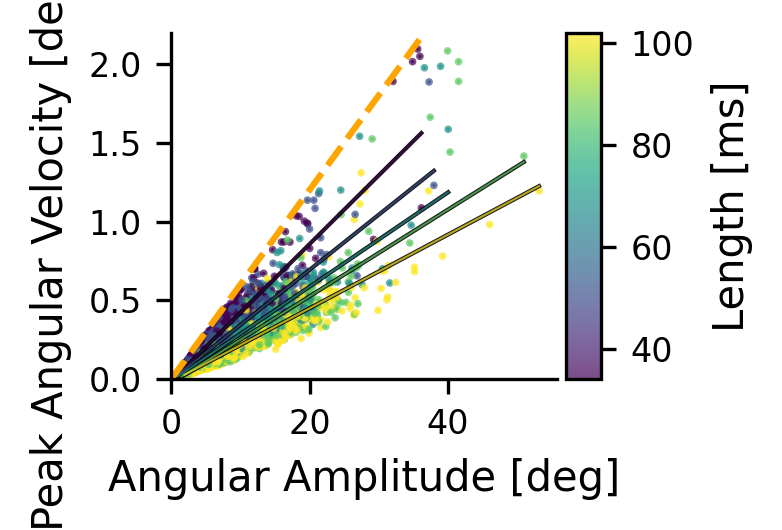

In [18]:
plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('length < 6'), non_synced_saccade_collection.query('length < 6'), export_path=None, threshold=15,
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

Saccades in plot (after equal sampling): 5030
Len=34 ms, R²=0.90, p=0 

Len=51 ms, R²=0.89, p=0 

Len=68 ms, R²=0.87, p=0 

Len=85 ms, R²=0.83, p=0 

Len=102 ms, R²=0.80, p=1.5e-272 



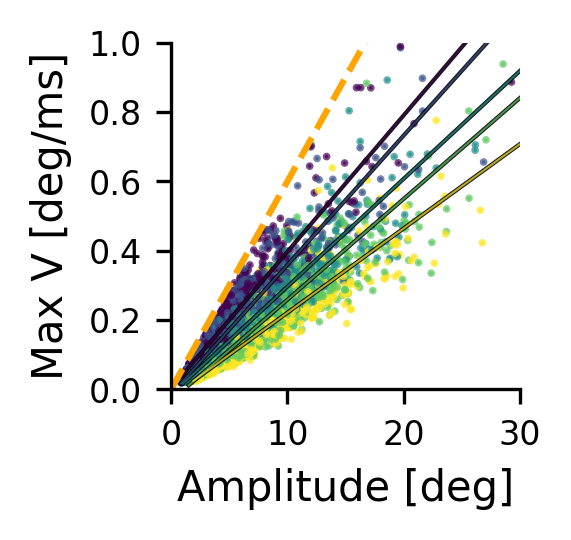

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from matplotlib.lines import Line2D
from scipy.stats import t
import datetime
import os
import pickle

def plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection, monocular_saccade_collection, export_path=None,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60
):
    """
    Plots angular saccade amplitudes versus angular peak velocities as a scatter plot.

    In this revised version:
      - All datapoints are kept (no outlier removal).
      - The data is grouped by animal (using the 'animal' column),
        and a random sampling is done so that each animal contributes the same number
        of datapoints (equal to the count of the animal with the fewest datapoints).
      - Angular metrics are computed as follows:
            magnitude: taken from 'magnitude_raw_angular' (in degrees)
            peak_velocity: maximum value from 'speed_profile_angular' (converted to deg/ms if desired)
            length: defined as the number of frames in 'speed_profile_angular' multiplied by 17 to convert to ms.

    Parameters:
      - synced_saccade_collection: DataFrame of synchronized saccades with angular columns and an 'animal' column.
      - monocular_saccade_collection: DataFrame of monocular saccades (unused, for compatibility).
      - export_path (str): Directory path to export the plot and data.
      - fig_size (tuple): Figure size (width, height).
      - velocity_threshold (float): Optional horizontal line value for peak velocities.
      - velocity_to_deg_per_ms (bool): If True, converts angular speeds from deg/frame to deg/ms.
      - frame_rate_fps (float): Frame rate in frames per second.
    """
    # Make a copy of the data and compute the key metrics.
    df = synced_saccade_collection.copy()

    # Ensure that an 'animal' column exists
    if 'animal' not in df.columns:
        raise ValueError("The input dataframe must contain an 'animal' column.")

    # Compute metrics:
    #  - 'magnitude' from 'magnitude_raw_angular'
    #  - 'peak_velocity' as the maximum of each speed profile
    #  - 'length' as the number of frames (converted to ms by multiplying by 17)
    df['magnitude'] = df['magnitude_raw_angular']
    df['peak_velocity'] = df['speed_profile_angular'].apply(np.nanmax)
    df['length'] = df['speed_profile_angular'].apply(lambda x: len(x)) * 17

    # Optionally convert angular peak velocity from deg/frame to deg/ms.
    if velocity_to_deg_per_ms:
        frame_duration = 1000 / frame_rate_fps  # ms per frame
        df['peak_velocity'] = df['peak_velocity'] / frame_duration

    # Group by animal and sample equally: find the smallest group size.
    grouped = df.groupby('animal')
    min_count = grouped.size().min()
    sampled_dfs = []
    for animal, group in grouped:
        # Randomly sample min_count rows from each animal group (using a fixed random_state for reproducibility)
        sampled_group = group.sample(n=min_count, random_state=42)
        sampled_dfs.append(sampled_group)

    sampled_data = pd.concat(sampled_dfs, axis=0)
    print(f'Saccades in plot (after equal sampling): {len(sampled_data)}')

    # Plot settings
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Scatter plot: angular amplitude (x-axis) vs. peak angular velocity (y-axis)
    # Points are colored by saccade length (in ms)
    sc = ax.scatter(sampled_data['magnitude'], sampled_data['peak_velocity'], s=0.7,
                    c=sampled_data['length'], cmap='viridis', alpha=0.7)

    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Max V [deg/ms]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Add optional horizontal line if a velocity_threshold is provided.
    if velocity_threshold is not None:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # Optionally, group data by saccade length and fit regression lines.
    grouped_data = sampled_data.groupby('length')
    norm = Normalize(vmin=sampled_data['length'].min(), vmax=sampled_data['length'].max())
    cmap_ = plt.cm.viridis

    for length, group in grouped_data:
        clean_group = group[['magnitude', 'peak_velocity']].dropna()
        x = clean_group['magnitude'].values.reshape(-1, 1)
        y = clean_group['peak_velocity'].values
        line_color = cmap_(norm(length))
        if len(x) > 1:
            model = LinearRegression().fit(x, y)
            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = model.score(x, y)
            y_pred = model.predict(x)
            residuals = y - y_pred
            rse = np.sqrt(np.sum(residuals**2) / (len(x) - 2))
            se_slope = rse / np.sqrt(np.sum((x - x.mean())**2))
            t_stat = slope / se_slope
            df_deg = len(x) - 2
            p_value = 2 * t.sf(np.abs(t_stat), df_deg)
            x_vals = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
            y_vals = model.predict(x_vals)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=1, color='black', alpha=0.9, zorder=1)
            ax.plot(x_vals, y_vals, linestyle='-', linewidth=0.5, color=line_color, alpha=0.7, zorder=2)
            legend_text = f'Len={length} ms, R²={r_squared:.2f}, p={p_value:.2g}'
            print(legend_text, '\n')

    # Add a reference line with slope = 1/frame_duration in deg/ms.
    frame_duration = 1000 / frame_rate_fps
    limiting_slope = 1 / frame_duration
    x_line = np.linspace(0, sampled_data['magnitude'].max(), 100)
    y_line = limiting_slope * x_line
    ax.plot(x_line, y_line, color='orange', linestyle='--', linewidth=1.5, label='Min Detectable Speed')

    # Add colorbar for saccade length (in ms)
    #cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    #cbar.set_label('Length [ms]', fontsize=10)
    #cbar.ax.tick_params(labelsize=8)
    ax.set_xlim(0,30)
    ax.set_ylim(0,1)

    # Handle export if export_path is provided.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "sampled_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(sampled_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection.query('length < 6'), non_synced_saccade_collection, export_path=None,
    fig_size=(1.5, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

saccades in plot: 6876
Len=34 ms, R²=0.92, p=0 

Len=51 ms, R²=0.90, p=0 

Len=68 ms, R²=0.89, p=0 

Len=85 ms, R²=0.84, p=9.3e-256 



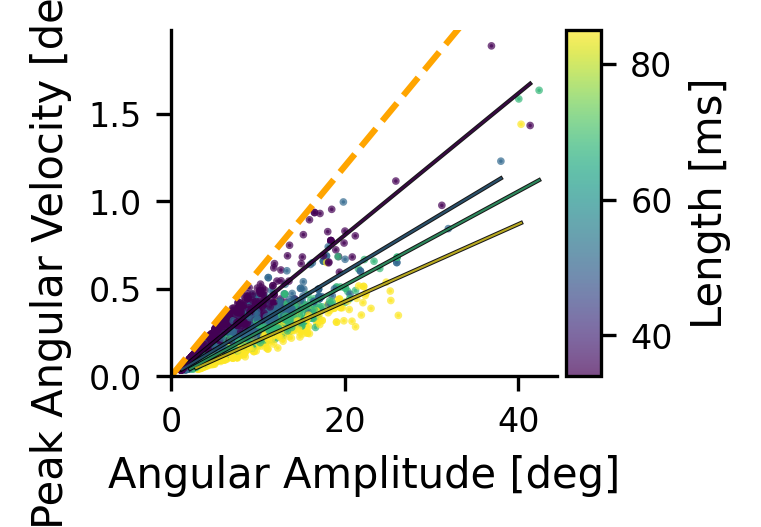

In [25]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'

plot_saccade_magnitude_vs_velocity_length_angular(
    synced_saccade_collection.query('animal=="PV_126" and length < 5'), non_synced_saccade_collection.query('animal=="PV_126" and length < 5'), export_path=None, threshold=15,
    fig_size=(2, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60)

Saccades in plot (after equal sampling & cleaning): 5030
Len=33 ms | log10(V)= +1.568 + 1.042·log10(A) | R²=0.96, p=0
Len=50 ms | log10(V)= +1.454 + 1.094·log10(A) | R²=0.95, p=0
Len=67 ms | log10(V)= +1.333 + 1.135·log10(A) | R²=0.95, p=0
Len=83 ms | log10(V)= +1.235 + 1.152·log10(A) | R²=0.92, p=0
Len=100 ms | log10(V)= +1.132 + 1.196·log10(A) | R²=0.91, p=0
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length\saccade_magnitude_vs_velocity_length_angular_2025_09_01_17_38_17


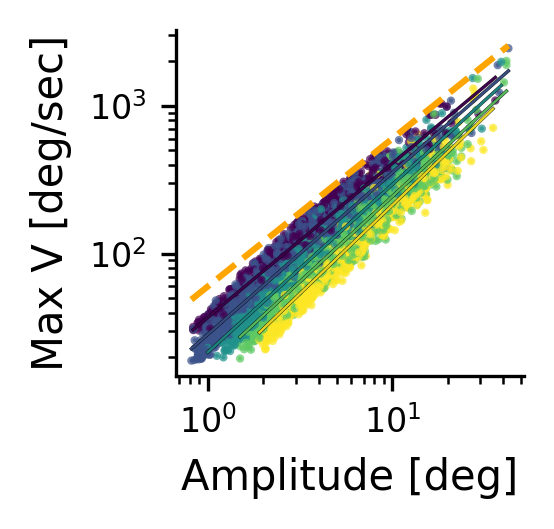

In [46]:
# over here, we correct the fit to power law
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from matplotlib.colors import Normalize
from scipy.stats import t
import datetime
import os
import pickle

def plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection, monocular_saccade_collection, export_path=None,
    fig_size=(3, 3), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60,
    log_scale=True, min_points_per_group=3
):
    """
    Plots angular saccade amplitude (deg) vs peak angular velocity (deg/sec) with log–log scaling
    and per-length power-law fits.

    Key behavior:
      - y in deg/sec (deg/frame × fps).
      - length in ms = (#frames) × (1000/fps).
      - Equal samples per animal (random, size of smallest animal group).
      - Regression is done in log10 space: log10(V) = a + b*log10(A)  ->  V = 10^a * A^b
        (fits and R² computed in log10 space; lines plotted back in linear space).
      - Frame-limited reference line: V = fps * A (slope 1 in log–log).

    Args:
      synced_saccade_collection : DataFrame with columns:
          - 'animal'
          - 'magnitude_raw_angular' (deg)
          - 'speed_profile_angular' (array-like of deg/frame values)
      monocular_saccade_collection : unused (kept for signature compatibility)
      export_path : optional directory to export PDF + sampled data pickle
      fig_size : tuple, inches
      velocity_threshold : float or None; horizontal line in deg/sec
      velocity_to_deg_per_ms : kept for backward compat; if True, convert to deg/sec
      frame_rate_fps : float; camera rate
      log_scale : bool; if True, uses log–log axes
      min_points_per_group : int; minimum positive (A,V) points required to fit a line per length group
    """
    # --- Copy and basic checks ---
    df = synced_saccade_collection.copy()
    if 'animal' not in df.columns:
        raise ValueError("The input dataframe must contain an 'animal' column.")

    # --- Compute metrics ---
    frame_duration_ms = 1000.0 / float(frame_rate_fps)  # ms per frame

    # Amplitude in deg
    df['magnitude'] = df['magnitude_raw_angular']

    # Peak velocity in deg/frame -> will convert to deg/sec
    df['peak_velocity'] = df['speed_profile_angular'].apply(np.nanmax)

    # Length in ms
    df['length'] = df['speed_profile_angular'].apply(
        lambda x: len(x) if hasattr(x, '__len__') else np.nan
    ) * frame_duration_ms

    # Convert to deg/sec (flag name retained for back-compat)
    if velocity_to_deg_per_ms:
        df['peak_velocity'] = df['peak_velocity'] * float(frame_rate_fps)

    # --- Equalize samples per animal ---
    grouped_anim = df.groupby('animal')
    min_count = grouped_anim.size().min()
    sampled_dfs = []
    for animal, group in grouped_anim:
        if min_count is None or min_count < 1:
            continue
        sampled_group = group.sample(n=min_count, random_state=42)
        sampled_dfs.append(sampled_group)
    if not sampled_dfs:
        raise ValueError("No data available after grouping/sampling; check input data.")
    sampled_data = pd.concat(sampled_dfs, axis=0)

    # Keep only rows with finite numbers
    sampled_data = sampled_data.replace([np.inf, -np.inf], np.nan)
    sampled_data = sampled_data.dropna(subset=['magnitude', 'peak_velocity', 'length'])

    print(f"Saccades in plot (after equal sampling & cleaning): {len(sampled_data)}")

    # --- Plot ---
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    sc = ax.scatter(
        sampled_data['magnitude'],
        sampled_data['peak_velocity'],
        s=1,
        c=sampled_data['length'],
        cmap='viridis',
        alpha=0.7
    )

    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Max V [deg/sec]', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Log–log axes (recommended for revealing low-A, low-V structure)
    if log_scale:
        ax.set_xscale('log')
        ax.set_yscale('log')

    # Optional horizontal threshold in deg/sec (works fine on log y)
    if velocity_threshold is not None and np.isfinite(velocity_threshold) and velocity_threshold > 0:
        ax.axhline(y=velocity_threshold, color='red', linestyle='--', linewidth=1.5)

    # --- Per-length power-law (log–log) regressions ---
    # We group by exact length (ms). If you prefer length bins, we can add that easily.
    grouped_len = sampled_data.groupby('length')

    norm = Normalize(vmin=sampled_data['length'].min(), vmax=sampled_data['length'].max())
    cmap_ = plt.cm.viridis

    def _fit_loglog_and_plot(x_lin, y_lin, color):
        """
        Fit log10(y) = a + b*log10(x), return (a, b, R2, pval) and draw the curve in linear space.
        """
        # Keep strictly positive pairs for log transform:
        mask = (x_lin > 0) & (y_lin > 0) & np.isfinite(x_lin) & np.isfinite(y_lin)
        x = x_lin[mask]
        y = y_lin[mask]
        if x.size < min_points_per_group:
            return None

        Xlog = np.log10(x).reshape(-1, 1)
        Ylog = np.log10(y)

        model = LinearRegression().fit(Xlog, Ylog)
        a = float(model.intercept_)        # log10(alpha)
        b = float(model.coef_[0])          # power exponent
        R2 = float(model.score(Xlog, Ylog))

        # p-value for slope in log space (simple linear regression)
        Yhat = model.predict(Xlog)
        resid = Ylog - Yhat
        n = len(Ylog)
        df_deg = n - 2
        if df_deg > 0:
            s2 = np.sum(resid**2) / df_deg
            Sxx = np.sum((Xlog - Xlog.mean())**2)
            if Sxx > 0:
                se_b = np.sqrt(s2 / Sxx)
                t_stat = b / se_b if se_b > 0 else np.inf
                p_val = 2 * t.sf(np.abs(t_stat), df_deg)
            else:
                p_val = np.nan
        else:
            p_val = np.nan

        # Draw the line as a power curve in linear space across the observed x-range
        x_line = np.logspace(np.log10(x.min()), np.log10(x.max()), 100)
        y_line = (10.0**a) * (x_line**b)
        ax.plot(x_line, y_line, linestyle='-', linewidth=0.8, color='black', alpha=0.9, zorder=1)
        ax.plot(x_line, y_line, linestyle='-', linewidth=0.6, color=color, alpha=0.9, zorder=2)

        return a, b, R2, p_val

    for length_ms, group in grouped_len:
        clean = group[['magnitude', 'peak_velocity']].dropna().to_numpy()
        if clean.shape[0] < min_points_per_group:
            continue
        x_lin = clean[:, 0].astype(float)
        y_lin = clean[:, 1].astype(float)
        line_color = cmap_(norm(length_ms))
        fit = _fit_loglog_and_plot(x_lin, y_lin, line_color)
        if fit is not None:
            a_log10, b_pow, R2, p_val = fit
            print(f"Len={length_ms:.0f} ms | log10(V)= {a_log10:+.3f} + {b_pow:.3f}·log10(A) | "
                  f"R²={R2:.2f}, p={p_val:.2g}")

    # --- Frame-limited reference line: V = fps * A (slope=1 in log–log) ---
    if len(sampled_data) > 0:
        x_min_pos = sampled_data['magnitude'][sampled_data['magnitude'] > 0].min()
        x_max_pos = sampled_data['magnitude'].max()
        if np.isfinite(x_min_pos) and np.isfinite(x_max_pos) and x_min_pos > 0 and x_max_pos > 0:
            x_ref = np.logspace(np.log10(x_min_pos), np.log10(x_max_pos), 100)
            y_ref = float(frame_rate_fps) * x_ref
            ax.plot(x_ref, y_ref, color='orange', linestyle='--', linewidth=1.5, label='Frame-limited (V = fps·A)')

    # Optional colorbar (length in ms)
    # cbar = plt.colorbar(sc, ax=ax, pad=0.02, aspect=10)
    # cbar.set_label('Length [ms]', fontsize=10)
    # cbar.ax.tick_params(labelsize=8)

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_magnitude_vs_velocity_length_angular_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_magnitude_vs_velocity_length_angular.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "sampled_saccade_data_length_angular.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(sampled_data, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\amplitude_velocity_length'
plot_saccade_magnitude_vs_velocity_length_angular_multiple_animals(
    synced_saccade_collection.query('length<6'), non_synced_saccade_collection, export_path=export_path,
    fig_size=(1.5, 1.5), velocity_threshold=None, velocity_to_deg_per_ms=True, frame_rate_fps=60,
    log_scale=True, min_points_per_group=3
)

In [23]:
6for block in block_collection:
    print(block)
    print('left:',block.L_pix_size)
    print('right:',block.R_pix_size)


PV_106, block 008, on PV106_ET_d3t12025-08-06_11-52-19
left: 0.0634
right: 0.05
PV_106, block 009, on PV106_ET_d3t2_2025-08-06_12-09-43
left: 0.0632
right: 0.05
PV_106, block 010, on PV106_ET_d3t3_2025-08-06_12-26-43
left: 0.0632
right: 0.0505
PV_106, block 011, on PV106_ET_d3t4_2025-08-06_12-44-30
left: 0.059000000000000004
right: 0.047
PV_106, block 012, on PV106_ET_d3t5_2025-08-06_13-21-30
left: 0.059000000000000004
right: 0.047
PV_143, block 001, on PV143_ET_d1t1_2025-08-11_13-29-08
left: 0.037000000000000005
right: 0.0417
PV_143, block 002, on PV143_ET_d1t2_2025-08-11_13-50-11
left: 0.037000000000000005
right: 0.0417
PV_143, block 003, on PV143_ET_d1t3_2025-08-11_14-20-35
left: 0.038
right: 0.0424
PV_143, block 004, on PV143_ET_d1t4_2025-08-11_14-58-28
left: 0.038
right: 0.0424
PV_62, block 024, on 2023-04-27_11-22-56
left: 0.045
right: 0.047
PV_62, block 026, on 2023-04-27_12-21-41
left: 0.045
right: 0.047
PV_62, block 038, on 2023-05-01_13-57-45
left: 0.04605644273172008
right: 

Value = 17, count = 1758
Value = 34, count = 479
Value = 51, count = 155
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented\angular_speed_profiles_2025_09_01_18_47_02


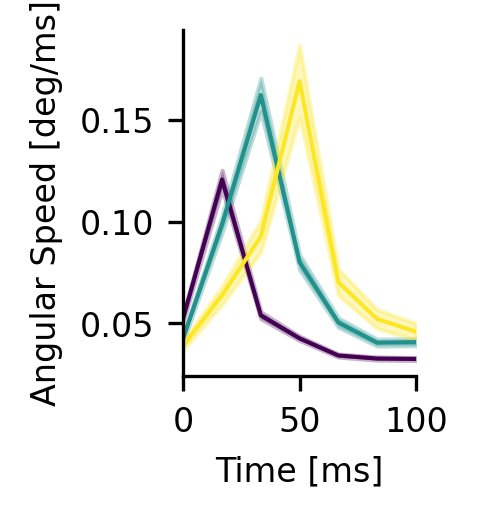

In [54]:
import datetime
import numpy as np
import cv2
from itertools import cycle
import pickle
import pathlib
import math
import tqdm
import scipy.io
import h5py
import re
from lxml import etree as ET
import scipy.signal as sig
import pandas as pd
from scipy.stats import kde, t
from matplotlib import pyplot as plt
from matplotlib import rcParams
plt.style.use('default')
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

def plot_speed_profiles_with_export_angular(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None, export_path=None,
    fig_size=(2.5,1.7), set_xlim=None
):
    """
    Plots average angular speed profiles grouped by unique time-to-peak values, up to a ceiling value.
    Angular speed profiles are taken from the 'speed_profile_angular' column, which is assumed to be in deg/frame.
    They are converted to deg/ms by dividing by the frame duration (1000/sampling_rate).

    Parameters:
      - saccade_collection: DataFrame containing angular speed profiles (in 'speed_profile_angular') and
                            time-to-peak values in 'time_to_peak_v'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - floor: Minimum time-to-peak value to include (optional).
      - ceiling: Maximum time-to-peak value to include (optional).
      - export_path: Directory path to export the plot and data (optional).
      - fig_size: Figure size (width, height).
      - set_xlim: Optional x-axis limits.
    """
    # Filter unique time-to-peak values and apply ceiling/floor if provided
    unique_time_to_peak_values = np.unique(saccade_collection['time_to_peak_v'].dropna().astype(int))
    if ceiling is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values <= ceiling]
    if floor is not None:
        unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= floor]
    unique_time_to_peak_values = unique_time_to_peak_values[unique_time_to_peak_values >= 0]

    # Prepare the figure
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=unique_time_to_peak_values.min(), vmax=unique_time_to_peak_values.max())

    # Calculate frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate  # e.g., ~16.67 ms at 60 Hz

    # Iterate over each unique time-to-peak value
    for idx, time_to_peak in enumerate(unique_time_to_peak_values):
        # Filter the angular speed profiles for the current time-to-peak value.
        # Note: We now use the 'speed_profile_angular' column.
        profiles = saccade_collection.loc[
            saccade_collection['time_to_peak_v'] == time_to_peak,
            'speed_profile_angular'
        ].dropna().values

        if len(profiles) == 0:
            continue

        # Convert each speed profile from deg/frame to deg/ms
        converted_profiles = []
        for profile in profiles:
            # Ensure profile is a NumPy array
            profile = np.array(profile)
            # Convert: deg/frame divided by (ms/frame) gives deg/ms.
            converted_profiles.append(profile / frame_duration)

        # Align the converted profiles to the same length
        max_length = max(len(p) for p in converted_profiles)
        aligned_profiles = np.full((len(converted_profiles), max_length), np.nan)
        for i, profile in enumerate(converted_profiles):
            aligned_profiles[i, :len(profile)] = profile

        # Compute average profile and standard error
        avg_profile = np.nanmean(aligned_profiles, axis=0)
        std_error = np.nanstd(aligned_profiles, axis=0) / np.sqrt(len(converted_profiles))

        # Define time points (in ms) for the profile based on sampling rate
        time_points = np.arange(0, len(avg_profile) * frame_duration, frame_duration)

        # If set_xlim is provided, filter the data to only include points within the specified range.
        if set_xlim is not None:
            lower_bound, upper_bound = set_xlim
            mask = (time_points >= lower_bound) & (time_points <= upper_bound)
            time_points = time_points[mask]
            avg_profile = avg_profile[mask]
            std_error = std_error[mask]

        # Plot the average speed profile with its error region
        ax.plot(time_points, avg_profile, color=cmap(norm(time_to_peak)), lw=1)
        ax.fill_between(time_points, avg_profile - std_error, avg_profile + std_error,
                        color=cmap(norm(time_to_peak)), alpha=0.3)

    if set_xlim is not None:
        ax.set_xlim(set_xlim)

    # Customize the plot labels and appearance
    ax.set_xlabel('Time [ms]', fontsize=8)
    ax.set_ylabel('Angular Speed [deg/ms]', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add a colorbar for time-to-peak values
    #sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    #sm.set_array([])
    #cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
    # Uncomment the following line if you wish to add a label to the colorbar:
    # cbar.set_label('Time-to-Peak [ms]', fontsize=8)

    # Print counts for debugging
    for value in unique_time_to_peak_values:
        count = len(saccade_collection.query('time_to_peak_v == @value'))
        print(f'Value = {value}, count = {count}')

    # Export the figure and data if export_path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"angular_speed_profiles_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "angular_speed_profiles.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_62" and head_movement==False'), sampling_rate=60, floor=1, ceiling=52, export_path=export_path, fig_size=(1,1.5), set_xlim=(0,100))

In [1]:
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles_segmented'
plot_speed_profiles_with_export_angular(all_saccade_collection.query('animal == "PV_62" and head_movement==False'), sampling_rate=60, floor=1, ceiling=52, export_path=export_path, fig_size=(1,1.5), set_xlim=(0,100))

NameError: name 'all_saccade_collection' is not defined

In [77]:
all_saccade_collection.columns

Index(['Main', 'Sub', 'saccade_start_ind', 'saccade_end_ind',
       'saccade_start_timestamp', 'saccade_end_timestamp', 'saccade_on_ms',
       'saccade_off_ms', 'length', 'magnitude_raw_pixel', 'magnitude_pixel',
       'magnitude_raw_angular', 'overall_angle_deg', 'net_angular_disp',
       'speed_profile_pixel', 'speed_profile_pixel_calib',
       'speed_profile_angular', 'diameter_profile', 'theta_init_pos',
       'theta_end_pos', 'phi_init_pos', 'phi_end_pos', 'delta_theta',
       'delta_phi', 'head_movement', 'eye', 'block', 'animal',
       'time_to_peak_v'],
      dtype='object')

Collect L: 100%|██████████| 2478/2478 [00:02<00:00, 1209.93it/s]


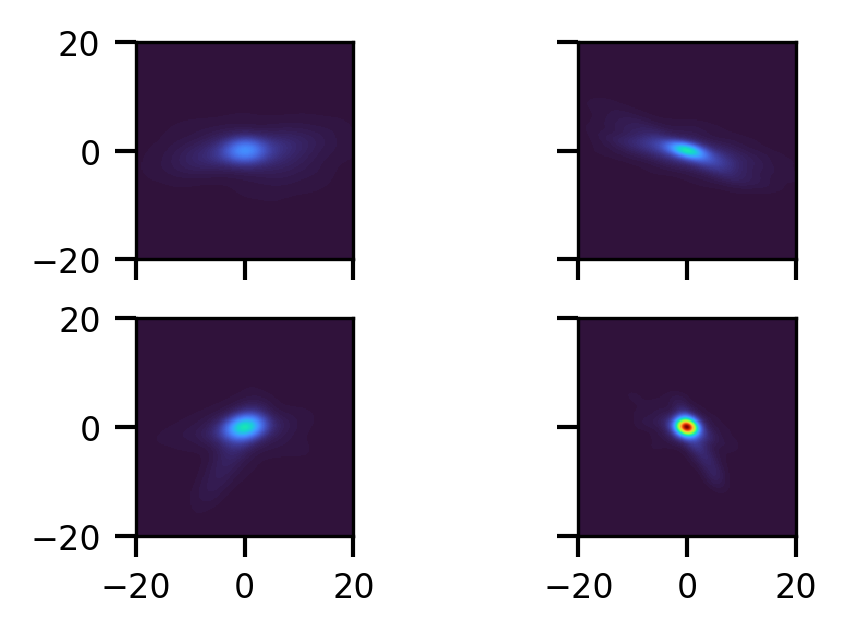

In [56]:
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5)
):
    """
    See original docstring; behavior unchanged except:
      - no per-axes titles
      - top-row x tick labels removed; right-column y tick labels removed
      - panels are square & undistorted (equal aspect and identical x/y limits)
      - colorbar exported as a separate PDF file when export_path is provided
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    from matplotlib.colors import Normalize
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, pathlib, tqdm

    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            x0, y0 = traj['center_x'].iloc[0], traj['center_y'].iloc[0]
            xs.extend((traj['center_x'] - x0).to_list())
            ys.extend((traj['center_y'] - y0).to_list())
        return np.asarray(xs), np.asarray(ys)

    # Gather points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns    = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns    = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if x.size == 0 or y.size == 0:
            return None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi = zi / zi.sum()  # normalize density to 1
        return xi, yi, zi

    kdeds = {
        ('synced', 'R'): evaluate_kde(r_x_synced, r_y_synced),
        ('synced', 'L'): evaluate_kde(l_x_synced, l_y_synced),
        ('non',    'R'): evaluate_kde(r_x_ns,    r_y_ns),
        ('non',    'L'): evaluate_kde(l_x_ns,    l_y_ns),
    }

    # Shared color scale (only over existing arrays)
    all_zi = [trip[2] for trip in kdeds.values() if trip is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0.0, 1.0)
    norm = Normalize(vmin=vmin, vmax=vmax)

    # Figure: 2x2 panels, square aspect, shared limits, no colorbar here
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=figsize, dpi=300,
        sharex=True, sharey=True, constrained_layout=True
    )

    # Helper to draw one heatmap without title
    def draw(ax, key):
        trip = kdeds.get(key, None)
        if trip is None:
            ax.set_xlim(global_min, global_max)
            ax.set_ylim(global_min, global_max)
            ax.set_aspect('equal', adjustable='box')
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
            return None
        _, _, zi = trip
        im = ax.imshow(
            zi.T,
            extent=[global_min, global_max, global_min, global_max],
            origin='lower', cmap=cmap, norm=norm, interpolation='nearest'
        )
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        ax.set_aspect('equal', adjustable='box')
        return im

    # Layout: [0,0]=Right Synced ; [0,1]=Left Synced ; [1,0]=Right Non ; [1,1]=Left Non
    draw(axes[0,0], ('synced','R'))
    draw(axes[0,1], ('synced','L'))
    draw(axes[1,0], ('non','R'))
    draw(axes[1,1], ('non','L'))

    # Remove titles
    for ax in axes.ravel():
        ax.set_title("")

    # Tick label visibility rules
    # - top row: hide x tick labels
    axes[0,0].tick_params(axis='x', labelbottom=False)
    axes[0,1].tick_params(axis='x', labelbottom=False)
    # - right column: hide y tick labels
    axes[0,1].tick_params(axis='y', labelleft=False)
    axes[1,1].tick_params(axis='y', labelleft=False)

    # (Optional) thin ticks & smaller font for compactness
    for ax in axes.ravel():
        ax.tick_params(which='both', width=1, length=5, labelsize=8)

    # Export(s)
    if export_path is not None:
        export_path = pathlib.Path(export_path)
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        out_dir = export_path / f"saccade_heatmaps_trajectories_{timestamp}"
        out_dir.mkdir(parents=True, exist_ok=True)

        # Main figure (no colorbar)
        fig.savefig(out_dir / "saccade_heatmaps_comparison_trajectories.pdf",
                    format='pdf', bbox_inches='tight', dpi=300)

        # Separate colorbar PDF
        if all_zi:
            # slim, vertical colorbar figure
            fig_cb, ax_cb = plt.subplots(figsize=(0.6, 2.0), dpi=300)
            sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
            sm.set_array([])
            cb = plt.colorbar(sm, ax=ax_cb)
            cb.set_label('Relative density', fontsize=9)
            ax_cb.remove()  # only keep the colorbar
            fig_cb.savefig(out_dir / "saccade_heatmaps_colorbar.pdf",
                           format='pdf', bbox_inches='tight', dpi=300)
            plt.close(fig_cb)

        # Save aggregated points for reproducibility
        with open(out_dir / "saccade_trajectories_data.pkl", "wb") as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'grid': {'nbins': nbins, 'global_min': global_min, 'global_max': global_max},
                'vmin_vmax': (vmin, vmax),
            }, f)

        print(f"Exported to: {out_dir}")

    plt.show()
%matplotlib inline
plt.style.use('default')
rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
rcParams['ps.fonttype'] = 42  # Ensure compatibility with vector outputs
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
synced_saccades = synced_saccade_collection.query('animal == "PV_106"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_106"')
plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict=block_dict,export_path=None, nbins=200,
                                       global_min=-20, global_max=20, cmap=plt.cm.turbo, figsize=(3, 2))

# This version tweaks the plot for the paper

Collect L: 100%|██████████| 838/838 [00:00<00:00, 1235.94it/s]


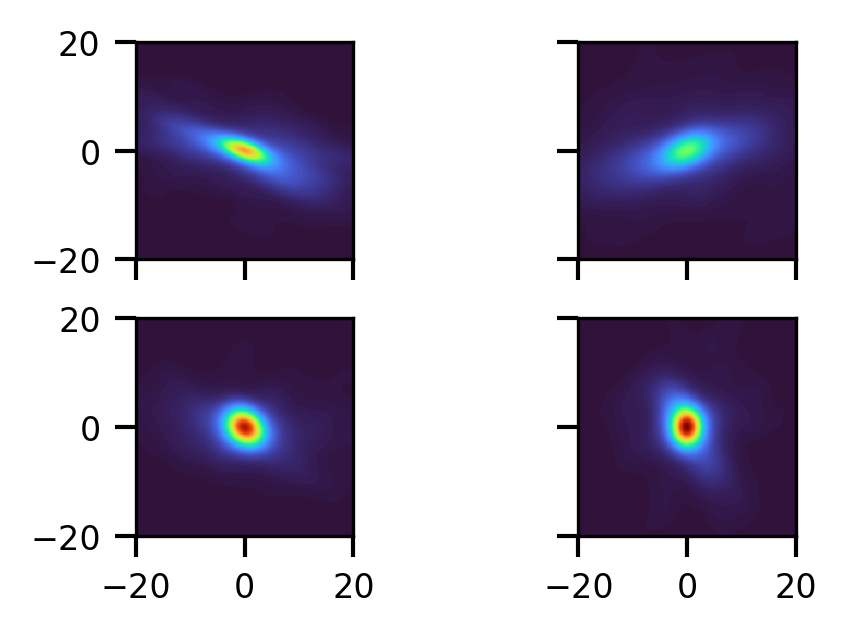

In [57]:
synced_saccades = synced_saccade_collection.query('animal == "PV_143"')
non_synced_saccades = non_synced_saccade_collection.query('animal == "PV_143"')
plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict=block_dict,export_path=None, nbins=200,
                                       global_min=-20, global_max=20, cmap=plt.cm.turbo, figsize=(3, 2))

1624it [00:01, 1186.27it/s]
1914it [00:01, 1241.01it/s]
1567it [00:01, 1172.44it/s]
2478it [00:02, 1198.19it/s]


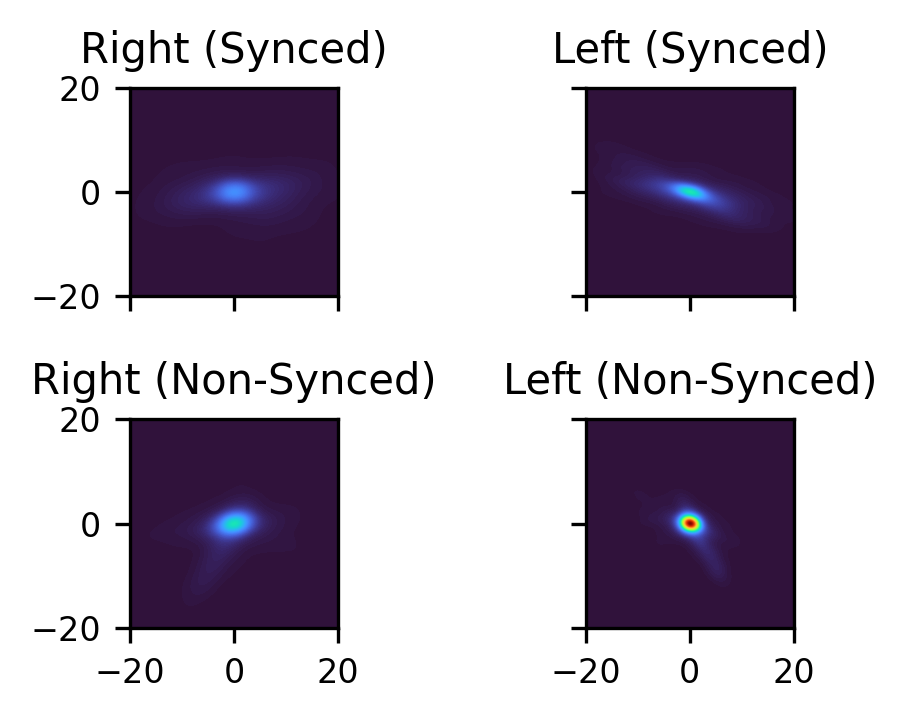

In [61]:
# this is an alternative approach for the heatmaps story, and it has the option to rotate according to 3D registration angles:


def plot_saccade_heatmaps_comparison_trajectories(synced_saccades, non_synced_saccades, block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-25, global_max=25,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5)):
    """
    Plots stacked 2D KDE heatmaps for synced (top row) and non-synced (bottom row) saccade trajectories.

    For each saccade event, this function:
      - Retrieves the block object from block_dict (using block number and animal).
      - Selects the appropriate eye DataFrame (block.left_eye_data or block.right_eye_data).
      - Extracts the trajectory using the ms_axis timestamps (saccade_on_ms and saccade_off_ms).
      - Zeroes the trajectory by subtracting its initial (center_x, center_y) coordinate.
      - Aggregates all points for each condition (synced vs. non-synced) and eye (R and L).
      - Computes and plots a 2D KDE of the aggregated points.

    Parameters:
      - synced_saccades: DataFrame with synced saccade events. Must include columns:
          'block', 'animal', 'eye', 'saccade_on_ms', 'saccade_off_ms'.
      - non_synced_saccades: DataFrame for non-synced saccade events (same columns).
      - block_dict: Dictionary mapping block keys (e.g. "PV_126_block_7") to block objects.
      - export_path: Optional export directory.
      - nbins: Number of bins for the KDE grid.
      - global_min, global_max: Limits for the KDE evaluation grid.
      - cmap: Colormap for the heatmap.
      - figsize: Figure size.

    Returns:
      - None. The function displays (and optionally exports) the heatmap plot.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os
    import datetime
    import pickle

    def extract_zeroed_points(saccades_df, eye):
        xs = []
        ys = []
        # Filter for the current eye (e.g., "L" or "R")
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows()):
            block_num = row['block']
            start_ms = row['saccade_on_ms']
            end_ms = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            # Choose the appropriate eye data based on row's 'eye'
            if eye == 'L':
                eye_df = block.left_eye_data
            elif eye == 'R':
                eye_df = block.right_eye_data
            else:
                continue
            # Extract the trajectory using the ms_axis time window
            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue
            # Zero the trajectory by subtracting the first coordinate
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            traj_x = traj['center_x'] - x0
            traj_y = traj['center_y'] - y0
            xs.extend(traj_x.tolist())
            ys.extend(traj_y.tolist())
        return np.array(xs), np.array(ys)

    # Extract zeroed trajectory points for synced and non-synced saccades, for both eyes.
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns, r_y_ns = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns, l_y_ns = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j, global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)  # Normalize so the total density equals 1
        return xi, yi, zi

    # Compute KDEs for each set of points.
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Determine a consistent color scale if any data exists.
    all_zi = [zi for zi in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if zi is not None]
    if all_zi:
        vmin = min(z.min() for z in all_zi)
        vmax = max(z.max() for z in all_zi)
    else:
        vmin, vmax = 0, 1

    # Create a 2x2 figure: top row for synced events; bottom row for non-synced; columns for R and L.
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300,
                             sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(zi.T, extent=[global_min, global_max, global_min, global_max],
                           origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', horizontalalignment='center', verticalalignment='center')
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s, yi_r_s, zi_r_s, 'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s, yi_l_s, zi_l_s, 'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Add a colorbar if at least one KDE was generated.
    # if im1 is not None:
    #     cax = fig.add_axes([0.92, 0.20, 0.02, 0.6])
    #     cb = plt.colorbar(im1, cax=cax)
    #     cb.set_label('Relative Density', fontsize=10)

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Optionally export the plot and aggregated trajectory data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)}
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_heatmaps_degree_verified')
plot_saccade_heatmaps_comparison_trajectories(synced_saccade_collection.query('animal=="PV_106"'), non_synced_saccade_collection.query('animal=="PV_106"'), block_dict,
                                                  export_path=None, nbins=200,
                                                  global_min=-20, global_max=20,
                                                  cmap=plt.cm.turbo, figsize=(4, 2.5))

Collect R:  14%|█▍        | 96/663 [00:00<00:00, 950.51it/s]

Discovered animals: ['PV_106', 'PV_126', 'PV_143', 'PV_57', 'PV_62']
[OK] PV_106 L: raw=+25.10°, axis_min=+25.10°
[OK] PV_106 R: raw=-17.29°, axis_min=-17.29°
[OK] PV_126 L: raw=-4.46°, axis_min=-4.46°
[OK] PV_126 R: raw=+6.42°, axis_min=+6.42°
[OK] PV_143 L: raw=-0.08°, axis_min=-0.08°
[OK] PV_143 R: raw=+3.55°, axis_min=+3.55°
[OK] PV_57 L: raw=+6.97°, axis_min=+6.97°
[OK] PV_57 R: raw=-7.68°, axis_min=-7.68°
[OK] PV_62 L: raw=-7.33°, axis_min=-7.33°
[OK] PV_62 R: raw=-6.56°, axis_min=-6.56°


Collect L: 100%|██████████| 838/838 [00:00<00:00, 1152.88it/s]


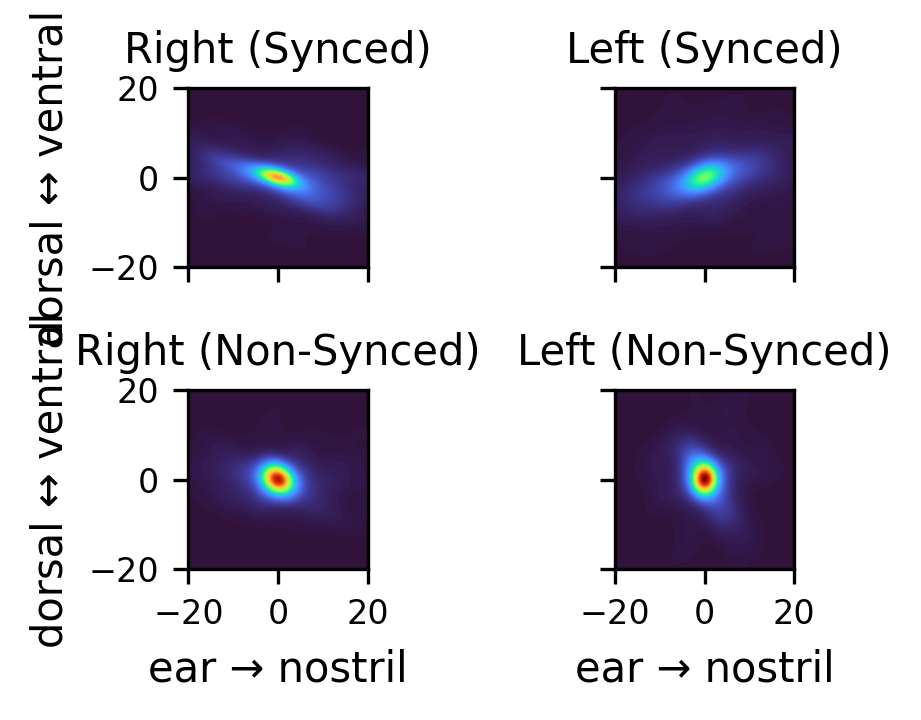

In [62]:
import re, json
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, Tuple, List, Optional

# ---------------- math helpers ----------------
def _wrap180(x_deg: float) -> float:
    return ((x_deg + 180.0) % 360.0) - 180.0

def _minimal_axis_lock_rotation(candidate_deg: float) -> float:
    """
    Axis equivalence: 0° ≡ 180°. Choose smallest-magnitude representative.
    Fold into [-90, +90).
    """
    alts = [candidate_deg, candidate_deg + 180.0, candidate_deg - 180.0]
    best = min(alts, key=lambda ang: abs(_wrap180(ang)))
    best = _wrap180(best)
    if abs(best) > 90.0:
        best = best - 180.0 * np.sign(best)
    return float(best)

def _quat_from_R(R: np.ndarray) -> np.ndarray:
    """3x3 rotation matrix -> unit quaternion (w,x,y,z), robust."""
    R = np.asarray(R, dtype=float)
    t = np.trace(R)
    if t > 0:
        s = np.sqrt(t + 1.0) * 2.0
        w = 0.25 * s
        x = (R[2,1] - R[1,2]) / s
        y = (R[0,2] - R[2,0]) / s
        z = (R[1,0] - R[0,1]) / s
    else:
        i = int(np.argmax([R[0,0], R[1,1], R[2,2]]))
        if i == 0:
            s = np.sqrt(1.0 + R[0,0] - R[1,1] - R[2,2]) * 2.0
            w = (R[2,1] - R[1,2]) / s; x = 0.25 * s
            y = (R[0,1] + R[1,0]) / s; z = (R[0,2] + R[2,0]) / s
        elif i == 1:
            s = np.sqrt(1.0 - R[0,0] + R[1,1] - R[2,2]) * 2.0
            w = (R[0,2] - R[2,0]) / s; x = (R[0,1] + R[1,0]) / s
            y = 0.25 * s;             z = (R[1,2] + R[2,1]) / s
        else:
            s = np.sqrt(1.0 - R[0,0] - R[1,1] + R[2,2]) * 2.0
            w = (R[1,0] - R[0,1]) / s; x = (R[0,2] + R[2,0]) / s
            y = (R[1,2] + R[2,1]) / s; z = 0.25 * s
    q = np.array([w, x, y, z], dtype=float)
    return q / np.linalg.norm(q)

def _twist_about_axis_deg(R: np.ndarray, axis_unit: np.ndarray) -> float:
    """
    Swing–twist decomposition: signed twist angle (deg) about axis_unit (right-hand rule).
    """
    q = _quat_from_R(R)
    w, v = q[0], q[1:]
    n = axis_unit / (np.linalg.norm(axis_unit) or 1.0)
    v_par = n * np.dot(v, n)
    q_tw = np.concatenate([[w], v_par])
    nrm = np.linalg.norm(q_tw)
    if nrm < 1e-12:
        return 0.0
    q_tw /= nrm
    ang = 2.0 * np.arctan2(np.linalg.norm(q_tw[1:]), q_tw[0])
    sign = np.sign(np.dot(v, n)) if np.linalg.norm(v_par) > 1e-12 else 1.0
    return float(np.degrees(ang) * sign)

# ---------------- I/O helpers for your layout ----------------
def _animal_from_folder(folder_name: str) -> Optional[str]:
    """
    Extract 'PV_###' from '<PV_###>_registration' folder names.
    """
    m = re.fullmatch(r'(PV_\d{2,3})_registration', folder_name)
    return m.group(1) if m else None

def discover_animals_under_root(root: Path) -> List[str]:
    """
    Scan root for folders named 'PV_###_registration' and return ['PV_###', ...].
    """
    animals = []
    for p in root.iterdir():
        if p.is_dir():
            a = _animal_from_folder(p.name)
            if a:
                animals.append(a)
    animals.sort()
    return animals

def _paths_for_animal(root: Path, animal: str) -> Dict[str, Dict[str, Path]]:
    """
    Build the exact file paths per your convention.

    Returns:
      {
        'L': {'rot': Path, 'normals': Path},
        'R': {'rot': Path, 'normals': Path}
      }
    """
    base = root / f"{animal}_registration"
    paths = {
        'L': {
            'rot':     base / "l_rot_matrix_v14.json",
            'normals': base / "l_normals_v14.json",
        },
        'R': {
            'rot':     base / "r_rot_matrix_v14.json",
            'normals': base / "r_normals_v14.json",
        }
    }
    return paths

def _load_rot_and_nref(rot_path: Path, normals_path: Path):
    R = np.array(json.loads(rot_path.read_text()), dtype=float).reshape(3,3)
    d = json.loads(normals_path.read_text())
    n_ref = np.array(d['n_ref'], dtype=float)
    n_ref = n_ref / (np.linalg.norm(n_ref) or 1.0)
    return R, n_ref

# ---------------- main catalog builder for your layout ----------------
def build_blender_roll_catalog_from_registration(
    root: Path,
    animals: Optional[List[str]] = None,
    verbose: bool = True,
) -> Dict[Tuple[str, str], float]:
    """
    Build {(animal,'L'|'R'): roll_deg_axis_min} using the fixed path layout:
      <root>/<animal>_registration/l_rot_matrix_v14.json, l_normals_v14.json, ...
    If animals is None, animals are discovered from folder names under root.
    """
    if animals is None:
        animals = discover_animals_under_root(root)
        if verbose:
            print(f"Discovered animals: {animals}")

    catalog: Dict[Tuple[str,str], float] = {}
    for animal in animals:
        files = _paths_for_animal(root, animal)
        for eye in ('L', 'R'):
            rot_p, nrm_p = files[eye]['rot'], files[eye]['normals']
            if not rot_p.exists() or not nrm_p.exists():
                if verbose:
                    print(f"[MISS] {animal} {eye}: missing files "
                          f"({rot_p.name if rot_p.exists() else 'NO rot'}, "
                          f"{nrm_p.name if nrm_p.exists() else 'NO normals'})")
                continue
            try:
                R, n_ref = _load_rot_and_nref(rot_p, nrm_p)
                roll_raw = _twist_about_axis_deg(R, n_ref)             # signed twist about n_ref
                roll_axis_min = _minimal_axis_lock_rotation(roll_raw)  # fold to axis measure [-90,+90)
                catalog[(animal, eye)] = float(roll_axis_min)
                if verbose:
                    print(f"[OK] {animal} {eye}: raw={roll_raw:+.2f}°, axis_min={roll_axis_min:+.2f}°")
            except Exception as e:
                if verbose:
                    print(f"[ERR] {animal} {eye}: {e}")
    return catalog
def plot_saccade_heatmaps_comparison_trajectories(
    synced_saccades, non_synced_saccades, block_dict,
    export_path=None, nbins=200,
    global_min=-25, global_max=25,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=None   # {(animal,'L'|'R'): rotation_deg}; optional
):
    """
    Same behavior as your latest version, but trajectories are rotated per-eye by
    the Blender-registered angle so that +X ≈ ear→nostril and +Y ≈ dorsal.
    Angles are degrees; positive means CCW rotation of image coordinates.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde
    import os, datetime, pickle, tqdm

    # ---------- helpers ----------
    def _deg2rad(d):
        return np.deg2rad(d)

    def _rotate2d(x, y, deg):
        """Rotate (x,y) by +deg (CCW). Works with numpy arrays."""
        if x.size == 0:
            return x, y
        th = _deg2rad(deg)
        c, s = np.cos(th), np.sin(th)
        xr = c * x - s * y
        yr = s * x + c * y
        return xr, yr

    def _per_eye_rotation(animal, eye):
        """Fetch per-eye rotation in degrees; 0 if catalog not provided/missing."""
        if rotation_catalog is None:
            return 0.0
        return float(rotation_catalog.get((animal, eye), 0.0))

    # ---------- core ----------
    def extract_zeroed_points(saccades_df, eye):
        xs, ys = [], []
        df_eye = saccades_df[saccades_df['eye'] == eye]
        for _, row in tqdm.tqdm(df_eye.iterrows(), total=len(df_eye), desc=f"Collect {eye}"):
            block_num = row['block']
            start_ms  = row['saccade_on_ms']
            end_ms    = row['saccade_off_ms']
            block_key = f"{row['animal']}_block_{block_num}"
            if block_key not in block_dict:
                continue
            block = block_dict[block_key]
            eye_df = block.left_eye_data if eye == 'L' else block.right_eye_data if eye == 'R' else None
            if eye_df is None:
                continue

            traj = eye_df[(eye_df['ms_axis'] >= start_ms) & (eye_df['ms_axis'] <= end_ms)]
            if traj.empty:
                continue

            # zero at onset
            x0 = traj['center_x'].iloc[0]
            y0 = traj['center_y'].iloc[0]
            dx = (traj['center_x'] - x0).to_numpy(dtype=float)
            dy = (traj['center_y'] - y0).to_numpy(dtype=float)

            # per-eye rotation (deg) from Blender registration
            rot_deg = _per_eye_rotation(row['animal'], eye)
            if rot_deg != 0.0:
                dx, dy = _rotate2d(dx, dy, rot_deg)

            xs.extend(dx.tolist())
            ys.extend(dy.tolist())
        return np.asarray(xs, dtype=float), np.asarray(ys, dtype=float)

    # Extract zeroed & rotated trajectory points
    r_x_synced, r_y_synced = extract_zeroed_points(synced_saccades, 'R')
    l_x_synced, l_y_synced = extract_zeroed_points(synced_saccades, 'L')
    r_x_ns,    r_y_ns      = extract_zeroed_points(non_synced_saccades, 'R')
    l_x_ns,    l_y_ns      = extract_zeroed_points(non_synced_saccades, 'L')

    def evaluate_kde(x, y):
        if len(x) == 0 or len(y) == 0:
            return None, None, None
        k  = gaussian_kde(np.vstack([x, y]).astype(float))
        xi, yi = np.mgrid[global_min:global_max:nbins*1j,
                          global_min:global_max:nbins*1j]
        zi = k(np.vstack([xi.ravel(), yi.ravel()])).reshape(xi.shape)
        zi /= np.sum(zi)
        return xi, yi, zi

    # KDEs
    xi_r_s, yi_r_s, zi_r_s = evaluate_kde(r_x_synced, r_y_synced)
    xi_l_s, yi_l_s, zi_l_s = evaluate_kde(l_x_synced, l_y_synced)
    xi_r_ns, yi_r_ns, zi_r_ns = evaluate_kde(r_x_ns, r_y_ns)
    xi_l_ns, yi_l_ns, zi_l_ns = evaluate_kde(l_x_ns, l_y_ns)

    # Shared color scale
    all_zi = [z for z in [zi_r_s, zi_l_s, zi_r_ns, zi_l_ns] if z is not None]
    vmin, vmax = (min(z.min() for z in all_zi), max(z.max() for z in all_zi)) if all_zi else (0, 1)

    # Figure
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize, dpi=300, sharey=True, sharex=True)

    def plot_heatmap(ax, xi, yi, zi, title):
        if zi is not None:
            im = ax.imshow(
                zi.T,
                extent=[global_min, global_max, global_min, global_max],
                origin='lower', cmap=cmap, vmin=vmin, vmax=vmax
            )
        else:
            im = None
            ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=8, transform=ax.transAxes)
        ax.set_title(title, fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.set_aspect('equal', 'box')
        return im

    im1 = plot_heatmap(axes[0, 0], xi_r_s,  yi_r_s,  zi_r_s,  'Right (Synced)')
    im2 = plot_heatmap(axes[0, 1], xi_l_s,  yi_l_s,  zi_l_s,  'Left (Synced)')
    im3 = plot_heatmap(axes[1, 0], xi_r_ns, yi_r_ns, zi_r_ns, 'Right (Non-Synced)')
    im4 = plot_heatmap(axes[1, 1], xi_l_ns, yi_l_ns, zi_l_ns, 'Left (Non-Synced)')

    # Label axes to reflect anatomical frame
    axes[1,0].set_xlabel("ear → nostril")
    axes[1,1].set_xlabel("ear → nostril")
    axes[0,0].set_ylabel("dorsal ↔ ventral")
    axes[1,0].set_ylabel("dorsal ↔ ventral")

    plt.tight_layout(rect=[0, 0, 0.9, 1])

    # Export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_heatmaps_trajectories_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_heatmaps_comparison_trajectories.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_trajectories_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced': {'R': (r_x_synced, r_y_synced), 'L': (l_x_synced, l_y_synced)},
                'non_synced': {'R': (r_x_ns, r_y_ns), 'L': (l_x_ns, l_y_ns)},
                'rotation_catalog': rotation_catalog
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()

# catalog_blender should be {(animal,'R'): deg, (animal,'L'): deg}
# e.g., from your JSON loader
from pathlib import Path

root = Path(r"D:\MarkS3\Documents\BlenderFiles\Camera_angle_registration")

# Option A: auto-discover animals from folder names like 'PV_62_registration'
catalog_blender = build_blender_roll_catalog_from_registration(root, animals=None, verbose=True)

plot_saccade_heatmaps_comparison_trajectories(
    synced_saccade_collection.query('animal=="PV_143"'),
    non_synced_saccade_collection.query('animal=="PV_143"'),
    block_dict,
    export_path=None,
    nbins=200, global_min=-20, global_max=20,
    cmap=plt.cm.turbo, figsize=(4, 2.5),
    rotation_catalog=catalog_blender   # <-- add this
)

In [31]:
# monocular saccade graph:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle


def process_profile(profile, expected_length):
    """
    Adjusts a profile to the expected length by either padding or snipping.
    """
    current_length = len(profile)

    if current_length == expected_length:
        return profile

    # Snip or pad to match the expected length
    if current_length > expected_length:
        excess = (current_length - expected_length) // 2
        return profile[excess:excess + expected_length]
    else:
        pad_before = (expected_length - current_length) // 2
        pad_after = expected_length - current_length - pad_before
        return np.pad(profile, (pad_before, pad_after), constant_values=np.nan)


def average_saccade_profile(non_synced_saccade_collection, block_dict, window_ms=200, sampling_rate=60,
                            export_path=None):
    half_window = window_ms // 2
    expected_length = int((window_ms / 1000) * sampling_rate)
    time_axis = (np.arange(expected_length) * 1000 / sampling_rate) - half_window

    saccade_profiles = []
    opposite_eye_profiles = []

    for _, row in non_synced_saccade_collection.iterrows():
        block_num = row['block']
        eye = row['eye']
        start_ts = row['saccade_on_ms']
        opposite_eye = 'L' if eye == 'R' else 'R'

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]
        current_eye_data = block.left_eye_data if eye == 'L' else block.right_eye_data
        opposite_eye_data = block.left_eye_data if opposite_eye == 'L' else block.right_eye_data

        saccade_profile = current_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values
        opposite_profile = opposite_eye_data.query(
            'ms_axis >= @start_ts - @half_window and ms_axis <= @start_ts + @half_window')['speed_r'].values

        if len(saccade_profile) == 0 or len(opposite_profile) == 0:
            print(f"Skipped saccade at {start_ts} due to missing data.")
            continue

        # Ensure fixed length through padding or snipping
        saccade_profiles.append(process_profile(saccade_profile, expected_length))
        opposite_eye_profiles.append(process_profile(opposite_profile, expected_length))

    if not saccade_profiles or not opposite_eye_profiles:
        print("No valid saccade profiles found.")
        return None, None

    avg_saccade = np.nanmean(np.vstack(saccade_profiles), axis=0)
    avg_opposite_eye = np.nanmean(np.vstack(opposite_eye_profiles), axis=0)

    # Plot the results
    fig, ax = plt.subplots(figsize=(1.7, 1.2), dpi=100)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    ax.tick_params(axis='both', which='major', length=5, color='black')
    ax.ticklabel_format(axis='y', style='plain')
    ax.set_ylabel("Speed (pixels/ms)", fontsize=10)
    ax.tick_params(axis='both', labelsize=8)
    ax.plot(time_axis, avg_saccade, label="Monocular Saccade", color='g')
    ax.plot(time_axis, avg_opposite_eye, label="Opposite Eye", color='b')
    ax.set_title("Average Saccade Profiles")
    ax.set_xlabel("Time (ms)")
    ax.legend(loc='center left', bbox_to_anchor=(0.6, 0.8), fontsize=6)
    plt.show()

    # Save results
    if export_path:
        t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f"Saccade_Profile_{t}"
        os.makedirs(export_dir, exist_ok=True)

        pdf_path = export_dir / "average_saccade_profiles.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')

        data_dict = {
            'time_axis': time_axis,
            'avg_saccade': avg_saccade,
            'avg_opposite_eye': avg_opposite_eye,
            'saccade_collection': non_synced_saccade_collection
        }
        pickle_path = export_dir / "saccade_profiles.pkl"
        with open(pickle_path, "wb") as f:
            pickle.dump(data_dict, f)
        print(f"Data saved to {export_dir}")

    return saccade_profiles, opposite_eye_profiles




37750it [01:05, 573.13it/s] 
<ipython-input-76-3240c26ddd47>:156: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig2.colorbar(sm, orientation='vertical')
<ipython-input-76-3240c26ddd47>:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


Number of data points: 23987


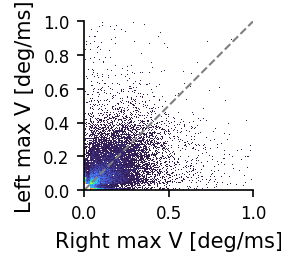

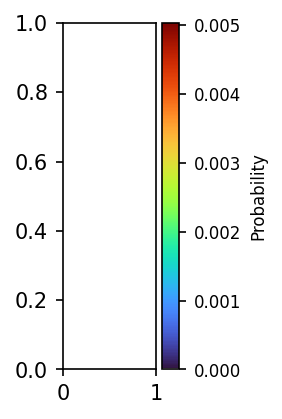

In [76]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31, value_range=(0,2)):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = value_range[0]
    max_value = value_range[1]

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()


t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None, iqr_multiplier=200, bins=200,value_range=(0,1))


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pandas as pd
import datetime
# %matplotlib inline  # keep as you prefer in your notebook
plt.style.use('default')
plt.rcParams['pdf.fonttype'] = 42  # Ensure fonts are embedded and editable
plt.rcParams['ps.fonttype']  = 42  # Ensure compatibility with vector outputs


def plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict, export_path=None,
    iqr_multiplier=1.5, bins=100, sync_diff_threshold=31,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_n_ticks=6, micro_n_ticks=6,
    macro_tick_list=None, micro_tick_list=None
):
    """
    Two-panel version: side-by-side 2D histograms of Right vs Left peak angular speed.

    Tick control:
      - If macro_tick_list / micro_tick_list are provided, use them directly.
      - Otherwise fall back to evenly spaced ticks (macro_n_ticks / micro_n_ticks).

    Exports: main figure PDF and a standalone colorbar PDF.
    """

    # ---- data extraction (kept from your corrected logic) ----
    right_eye_speeds, left_eye_speeds, animals_for_weights = [], [], []
    processed_events = {}

    def estimate_frame_period_ms(eye_df, t_ms):
        try:
            window = eye_df.query('ms_axis >= @t_ms - 51 and ms_axis <= @t_ms + 51')['ms_axis'].values
            if window.size >= 3:
                diffs = np.diff(np.sort(window))
                fp = np.nanmedian(diffs)
                if np.isfinite(fp) and fp > 0:
                    return fp
        except Exception:
            pass
        diffs_global = np.diff(eye_df['ms_axis'].values)
        fp_global = np.nanmedian(diffs_global[np.isfinite(diffs_global)])
        return fp_global if (np.isfinite(fp_global) and fp_global > 0) else 17.0

    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        if key in processed_events:
            if any(abs(current_timestamp - ts) <= sync_diff_threshold for ts in processed_events[key]):
                continue
            processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue
        block = block_dict[block_key]

        if row['eye'] == 'L':
            ipsi_eye_df = block.left_eye_data
            contra_eye_df = block.right_eye_data
            contra_series = contra_eye_df.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            ipsi_eye_df = block.right_eye_data
            contra_eye_df = block.left_eye_data
            contra_series = contra_eye_df.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        frame_period_ms = estimate_frame_period_ms(ipsi_eye_df, current_timestamp)
        max_detected = (np.nanmax(row['speed_profile_angular']) / frame_period_ms
                        if len(row['speed_profile_angular']) > 0 else np.nan)
        max_contra = (np.nanmax(contra_series.values) / frame_period_ms
                      if contra_series.notna().sum() > 0 else np.nan)

        if not np.isnan(max_detected) and not np.isnan(max_contra):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected); right_eye_speeds.append(max_contra)
            else:
                right_eye_speeds.append(max_detected); left_eye_speeds.append(max_contra)
            animals_for_weights.append(row['animal'])

    right_eye_speeds = np.array(right_eye_speeds, dtype=float)
    left_eye_speeds  = np.array(left_eye_speeds,  dtype=float)
    animals_for_weights = np.array(animals_for_weights)

    print("Number of data points:", len(right_eye_speeds))
    if len(right_eye_speeds) == 0:
        print("No valid data to plot.")
        return

    # Equal animal weighting
    if animals_for_weights.size:
        unique_animals, counts = np.unique(animals_for_weights, return_counts=True)
        inv_count = {a: 1.0 / c for a, c in zip(unique_animals, counts)}
        weights = np.array([inv_count[a] for a in animals_for_weights], dtype=float)
        weights *= (len(weights) / np.sum(weights))
    else:
        weights = None

    # Per-eye IQR filtering
    def iqr_bounds(arr, mult):
        q1, q3 = np.percentile(arr, [25, 75]); iqr = q3 - q1
        return q1 - mult * iqr, q3 + mult * iqr
    r_low, r_high = iqr_bounds(right_eye_speeds, iqr_multiplier)
    l_low, l_high = iqr_bounds(left_eye_speeds,  iqr_multiplier)
    keep = (right_eye_speeds >= r_low) & (right_eye_speeds <= r_high) & \
           (left_eye_speeds  >= l_low) & (left_eye_speeds  <= l_high)
    right_eye_speeds, left_eye_speeds = right_eye_speeds[keep], left_eye_speeds[keep]
    if weights is not None:
        weights = weights[keep]

    # turbo with 0 set to white
    turbo = plt.get_cmap('turbo', 256)
    turbo_colors = turbo(np.linspace(0, 1, 256)); turbo_colors[0] = np.array([1, 1, 1, 1])
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    fig, axs = plt.subplots(1, 2, figsize=(3, 1.7), dpi=300, constrained_layout=True)
    vmax_all = 0.0

    for ax, rng, title, n_ticks, tick_list in zip(
        axs,
        [macro_range, micro_range],
        ["Macro", "Micro"],
        [macro_n_ticks, micro_n_ticks],
        [macro_tick_list, micro_tick_list]
    ):
        minv, maxv = rng
        xbins = np.linspace(minv, maxv, bins)
        ybins = np.linspace(minv, maxv, bins)
        counts, xedges, yedges = np.histogram2d(
            right_eye_speeds, left_eye_speeds, bins=[xbins, ybins], weights=weights
        )
        norm_counts = counts / counts.sum() if counts.sum() > 0 else counts
        vmax_panel = norm_counts.max() if norm_counts.size else 1.0
        vmax_all = max(vmax_all, float(vmax_panel))

        ax.pcolormesh(
            xedges, yedges, norm_counts.T, cmap=custom_turbo,
            vmin=0, vmax=vmax_panel, shading='auto'
        )

        # square, explicit limits
        ax.set_box_aspect(1)
        ax.set_xlim(minv, maxv); ax.set_ylim(minv, maxv)

        # enforce ticks: explicit list if given, else linspace fallback
        if tick_list is not None:
            ax.set_xticks(tick_list)
            ax.set_yticks(tick_list)
        else:
            ticks = np.linspace(minv, maxv, n_ticks)
            ax.set_xticks(ticks)
            ax.set_yticks(ticks)

        # diagonal line
        ax.plot([minv, maxv], [minv, maxv], ls='--', color='gray', lw=1)

        # labels and style
        ax.set_title(title, fontsize=8)
        ax.tick_params(axis='both', labelsize=7)
        if ax is axs[0]:
            ax.set_xlabel("Right max V [deg/ms]", fontsize=9)
            ax.set_ylabel("Left max V [deg/ms]", fontsize=9)
        else:
            ax.set_xlabel("Right [deg/ms]", fontsize=9)
            ax.set_ylabel("Left [deg/ms]", fontsize=9)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(False)

    # Export main figure
    export_dir = None
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        fig.savefig(export_dir / "right_vs_left_twopanels_clean.pdf", bbox_inches='tight')
        print("Saved two-panel figure to", export_dir)

    # Standalone colorbar
    sm = plt.cm.ScalarMappable(cmap=custom_turbo,
                               norm=plt.Normalize(vmin=0, vmax=vmax_all if vmax_all > 0 else 1))
    sm.set_array([])
    fig_cbar = plt.figure(figsize=(1.2, 3.2), dpi=150)
    cax = fig_cbar.add_axes([0.35, 0.1, 0.2, 0.8])
    cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)

    if export_dir is not None:
        fig_cbar.savefig(export_dir / "right_vs_left_twopanels_colormap.pdf", bbox_inches='tight')
        print("Saved standalone colorbar to", export_dir)

    plt.show()
    return fig, axs

In [ ]:

# ---------------- CALL (example) ----------------
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'

plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict,
    export_path=None,
    iqr_multiplier=60, bins=125,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_tick_list=[0,0.5,1.0,1.5,2.0], # adjust if you want more/fewer tick stops
    micro_tick_list=[0,0.1,0.2]
)


28792it [01:44, 275.01it/s]


Number of data points: 20487
Saved two-panel figure to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_01_15_54
Saved standalone colorbar to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_09_01_15_54


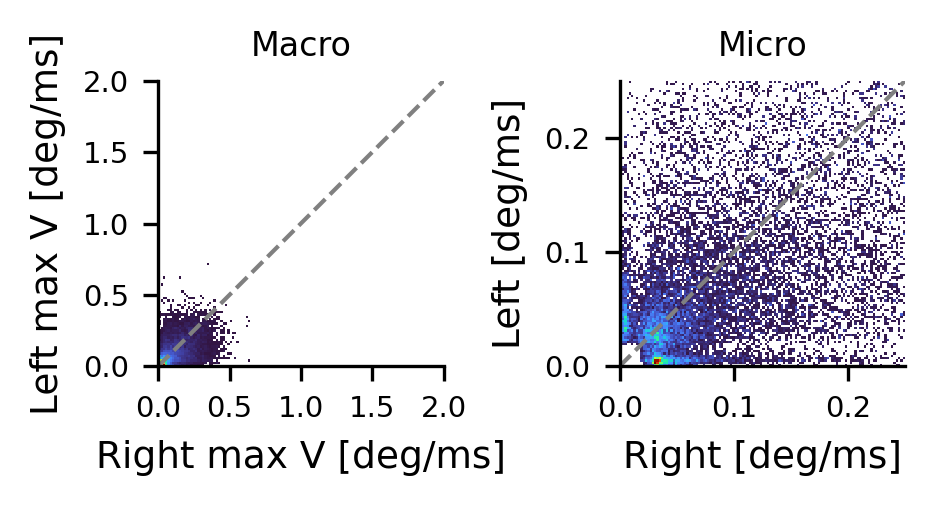

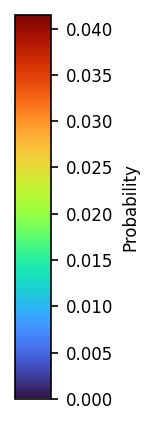

(<Figure size 900x510 with 2 Axes>,
 array([<Axes: title={'center': 'Macro'}, xlabel='Right max V [deg/ms]', ylabel='Left max V [deg/ms]'>,
        <Axes: title={'center': 'Micro'}, xlabel='Right [deg/ms]', ylabel='Left [deg/ms]'>],
       dtype=object))

In [42]:
# this one with no duplications:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d_twopanels(
    all_saccade_collection, block_dict,
    export_path=export_path,
    iqr_multiplier=60, bins=125,
    macro_range=(0, 2.0), micro_range=(0, 0.25),
    macro_tick_list=[0,0.5,1.0,1.5,2.0], # adjust if you want more/fewer tick stops
    micro_tick_list=[0,0.1,0.2]
)


37750it [01:02, 599.77it/s] 


Number of data points: 23987
2D histogram saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_08_24_11_40\right_vs_left_hist2d.pdf


<ipython-input-97-fc82c0351dd5>:156: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig2.colorbar(sm, orientation='vertical')


Colorbar saved to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\2025_08_24_11_40\right_vs_left_colorbar.pdf


<ipython-input-97-fc82c0351dd5>:159: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


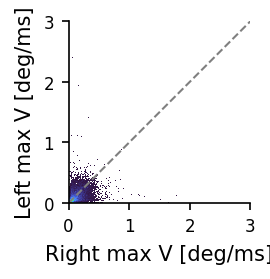

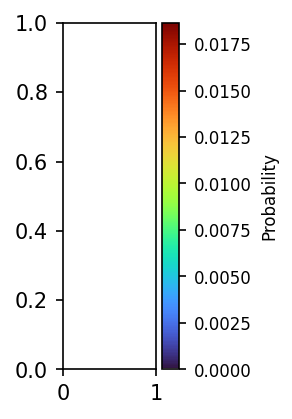

In [97]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pathlib
import tqdm
import pickle
import datetime
import pandas as pd  # Assuming pandas is imported as well

def plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=None,
                                  iqr_multiplier=1.5, bins=100, sync_diff_threshold=31):
    """
    Plots a 2D probability histogram (normalized so that the sum of all bins is 1) where the x-axis
    represents the right eye's max speed and the y-axis represents the left eye's max speed.
    Uses a custom colormap based on 'turbo' (with only the 0 value set to white) and applies a robust
    exclusion rule so that saccades that are within sync_diff_threshold of a previously processed saccade
    (for the same animal and block) are excluded.

    The axes are kept equal and the colorbar is saved to a separate PDF.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing detected saccades.
        block_dict (dict): Dictionary mapping block keys to block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot and colorbar PDFs.
        iqr_multiplier (float): Multiplier for the interquartile range (IQR) in outlier detection.
        bins (int): Number of bins to use for both x and y directions in the histogram.
        sync_diff_threshold (float): Time difference threshold to consider saccades synchronized
                                       (in the same units as 'saccade_on_ms').
    """
    right_eye_speeds = []
    left_eye_speeds = []

    # Dictionary to track processed saccades for each (animal, block).
    # Keys are (animal, block) and values are lists of saccade timestamps already used.
    processed_events = {}

    # Loop through each saccade entry.
    for _, row in tqdm.tqdm(all_saccade_collection.iterrows()):
        key = (row['animal'], row['block'])
        current_timestamp = row['saccade_on_ms']

        # Check if a saccade for this (animal, block) has already been processed
        # within sync_diff_threshold.
        if key in processed_events:
            if any(abs(current_timestamp - ts) < sync_diff_threshold for ts in processed_events[key]):
                continue  # Skip as this saccade is considered synchronized with a previous one.
            else:
                processed_events[key].append(current_timestamp)
        else:
            processed_events[key] = [current_timestamp]

        block_key = f"{row['animal']}_block_{row['block']}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get contralateral eye's data based on which eye was detected.
        if row['eye'] == 'L':
            contralateral_eye_speed_profile = block.right_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        elif row['eye'] == 'R':
            contralateral_eye_speed_profile = block.left_eye_data.query(
                'ms_axis >= @current_timestamp - 51 and ms_axis <= @current_timestamp + 51'
            )['angular_speed_r']
        else:
            continue

        # Compute the maximum speeds (scaling as in the original function)
        max_detected = np.nanmax(row['speed_profile_angular'] / 17) if len(row['speed_profile_angular']) > 0 else np.nan
        max_contralateral = (np.nanmax(contralateral_eye_speed_profile.values / 17)
                             if contralateral_eye_speed_profile.notna().sum() > 0 else np.nan)

        # Append valid pairs.
        if not np.isnan(max_detected) and not np.isnan(max_contralateral):
            if row['eye'] == 'L':
                left_eye_speeds.append(max_detected)
                right_eye_speeds.append(max_contralateral)
            elif row['eye'] == 'R':
                right_eye_speeds.append(max_detected)
                left_eye_speeds.append(max_contralateral)

    # Convert lists to NumPy arrays.
    right_eye_speeds = np.array(right_eye_speeds)
    left_eye_speeds = np.array(left_eye_speeds)
    print("Number of data points:", len(right_eye_speeds))

    # Outlier removal using IQR on the combined speeds.
    all_speeds = np.concatenate([right_eye_speeds, left_eye_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    valid_indices = ((right_eye_speeds >= lower_bound) & (right_eye_speeds <= upper_bound) &
                     (left_eye_speeds >= lower_bound) & (left_eye_speeds <= upper_bound))
    right_eye_speeds = right_eye_speeds[valid_indices]
    left_eye_speeds = left_eye_speeds[valid_indices]

    # Fixed axis limits.
    min_value = 0
    max_value = 3

    # Create the custom turbo colormap: get a discrete version of turbo and replace the first color with white.
    n_colors = 256
    turbo = plt.get_cmap('turbo', n_colors)
    turbo_colors = turbo(np.linspace(0, 1, n_colors))
    turbo_colors[0] = np.array([1, 1, 1, 1])  # Set the lowest count (0 probability) to perfect white.
    custom_turbo = mcolors.ListedColormap(turbo_colors)

    # Prepare the figure for the histogram.
    fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
    xbins = np.linspace(min_value, max_value, bins)
    ybins = np.linspace(min_value, max_value, bins)

    # Compute the 2D histogram manually.
    counts, xedges, yedges = np.histogram2d(right_eye_speeds, left_eye_speeds, bins=[xbins, ybins])
    normalized_counts = counts / counts.sum()  # Normalize so that the overall sum equals 1.

    # Plot the normalized histogram using pcolormesh.
    pc = ax.pcolormesh(xedges, yedges, normalized_counts.T, cmap=custom_turbo,
                         vmin=0, vmax=normalized_counts.max())

    # Ensure equal axes.
    ax.set_aspect('equal', 'box')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    # Add a diagonal reference line.
    ax.plot([min_value, max_value], [min_value, max_value], linestyle='--', color='gray', linewidth=1)

    # Set axis labels.
    ax.set_xlabel("Right max V [deg/ms]", fontsize=10)
    ax.set_ylabel("Left max V [deg/ms]", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)
    plt.tight_layout()

    # Save the histogram plot if export_path is provided.
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        hist_pdf_path = export_dir / "right_vs_left_hist2d.pdf"
        fig.savefig(hist_pdf_path, format='pdf', bbox_inches='tight')
        print(f"2D histogram saved to {hist_pdf_path}")

    # Create a separate figure for the colorbar.
    vmin_val = 0
    vmax_val = normalized_counts.max()
    sm = plt.cm.ScalarMappable(cmap=custom_turbo, norm=plt.Normalize(vmin=vmin_val, vmax=vmax_val))
    sm.set_array([])
    fig2 = plt.figure(figsize=(1, 3), dpi=150)
    cbar = fig2.colorbar(sm, orientation='vertical')
    cbar.set_label("Probability", fontsize=8)
    cbar.ax.tick_params(labelsize=8)
    plt.tight_layout()

    # Save the colorbar to a separate PDF if export_path is provided.
    if export_path:
        cbar_pdf_path = export_dir / "right_vs_left_colorbar.pdf"
        fig2.savefig(cbar_pdf_path, format='pdf', bbox_inches='tight')
        print(f"Colorbar saved to {cbar_pdf_path}")

    plt.show()

# Example usage:
t = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
export_path = rf'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\show_monocular_saccades\{t}'
plot_right_vs_left_eye_hist2d(all_saccade_collection, block_dict, export_path=export_path, iqr_multiplier=200, bins=250)


In [ ]:
def plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
):
    """
    Plots the correlation between the maximal angular speed and the overall amplitude of saccades.

    For each saccade (row in the dataframe), the function computes the maximal value of the
    'speed_profile_angular' array (converted from deg/frame to deg/ms using the provided sampling_rate)
    and compares it to the 'magnitude_raw_angular' value.

    A scatter plot is generated with a fitted regression line. The Pearson correlation coefficient
    and its p-value are printed and also shown on the plot.

    Parameters:
      - saccade_collection: DataFrame containing at least the columns 'speed_profile_angular' (an array)
                            and 'magnitude_raw_angular'.
      - sampling_rate: Sampling rate in Hz (default 60 Hz) used to convert speeds from deg/frame to deg/ms.
      - export_path: Optional directory path to export the plot and data.
      - fig_size: Tuple specifying the size (width, height) of the figure.
    """
    import os
    import datetime
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import pearsonr

    # Compute frame duration (ms per frame)
    frame_duration = 1000 / sampling_rate

    max_speeds = []
    amplitudes = []

    # Iterate over rows to compute maximum speed and corresponding amplitude
    for idx, row in saccade_collection.iterrows():
        profile = row['speed_profile_angular']
        amplitude = row['magnitude_raw_angular']
        # Check for missing data or empty profiles
        if profile is None or len(profile) == 0 or np.isnan(amplitude):
            continue
        # Convert profile to numpy array and convert to deg/ms
        profile = np.array(profile)
        # Compute maximum, ignoring any NaN values
        max_speed = np.nanmax(profile / frame_duration)
        max_speeds.append(max_speed)
        amplitudes.append(amplitude)

    max_speeds = np.array(max_speeds)
    amplitudes = np.array(amplitudes)

    if len(max_speeds) == 0:
        print("No valid saccade entries to compute correlation.")
        return

    # Compute Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(max_speeds, amplitudes)

    # Create scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    ax.scatter(max_speeds, amplitudes, s=10, color='blue', alpha=0.7)

    # Compute and plot the regression line
    slope, intercept = np.polyfit(max_speeds, amplitudes, 1)
    x_vals = np.linspace(max_speeds.min(), max_speeds.max(), 100)
    y_vals = slope * x_vals + intercept
    ax.plot(x_vals, y_vals, color='red', lw=1)

    # Label the plot
    ax.set_xlabel('Max Angular Speed [deg/ms]', fontsize=10)
    ax.set_ylabel('Overall Amplitude [deg]', fontsize=10)
    ax.set_title('Correlation between Max Angular Speed and Overall Amplitude', fontsize=12)
    ax.legend(fontsize=8)

    # Display correlation stats on the plot
    textstr = f'Pearson r = {corr_coef:.3f}\nP-value = {p_value:.3e}'
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=8, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    print(f"Pearson correlation coefficient: {corr_coef:.3f}")
    print(f"P-value: {p_value:.3e}")

    # Optionally export the plot and saccade data
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"max_speed_vs_amplitude_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "max_speed_vs_amplitude.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump(saccade_collection, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\correlation_plots'
plot_correlation_max_speed_vs_amplitude(
    saccade_collection, sampling_rate=60, export_path=None, fig_size=(4,3)
)

In [ ]:
synced_saccade_collection.columns

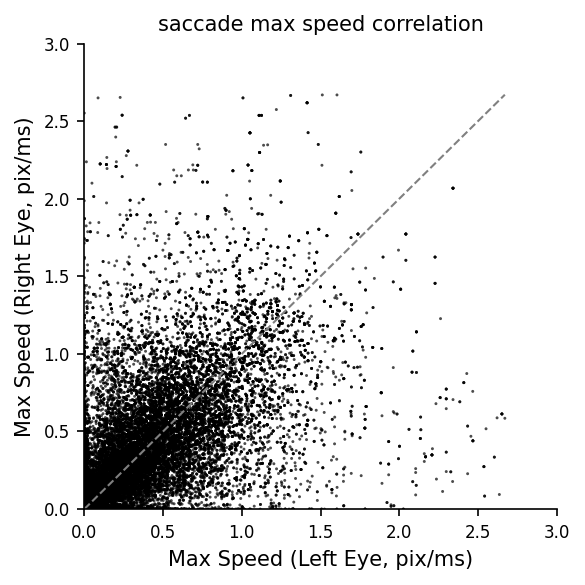

In [55]:


def plot_max_speeds_scatter(all_saccade_collection, block_dict, export_path=None,iqr_multiplier=1.5):
    """
    Plots a scatter plot of maximum speeds of the left eye vs the right eye for all saccades.

    Parameters:
        all_saccade_collection (pd.DataFrame): DataFrame containing all saccade data.
        block_dict (dict): Dictionary containing block objects with eye data.
        export_path (str or pathlib.Path, optional): Path to save the plot. Defaults to None.
    """
    left_eye_max_speeds = []
    right_eye_max_speeds = []

    for _, row in all_saccade_collection.iterrows():
        block_num = row['block']
        start_ts = row['saccade_on_ms']

        block_key = f"{row['animal']}_block_{block_num}"
        if block_key not in block_dict:
            continue

        block = block_dict[block_key]

        # Get speed data for the left and right eyes
        left_eye_data = block.left_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17
        right_eye_data = block.right_eye_data.query(
            'ms_axis >= @start_ts - 100 and ms_axis <= @start_ts + 100')['speed_r'].values / 17

        if len(left_eye_data) == 0 or len(right_eye_data) == 0:
            continue
        # Append maximum speeds only if valid data is available
        if not np.all(np.isnan(left_eye_data)):
            left_eye_max_speeds.append(np.nanmax(left_eye_data))
        else:
            left_eye_max_speeds.append(0)  # Or any other default value, like np.nan

        if not np.all(np.isnan(right_eye_data)):
            right_eye_max_speeds.append(np.nanmax(right_eye_data))
        else:
            right_eye_max_speeds.append(0)  # Or any other default value, like np.nan

    # Convert to NumPy arrays for easier filtering
    left_eye_max_speeds = np.array(left_eye_max_speeds)
    right_eye_max_speeds = np.array(right_eye_max_speeds)

    # Outlier removal using the IQR method
    all_speeds = np.concatenate([left_eye_max_speeds, right_eye_max_speeds])
    q1, q3 = np.percentile(all_speeds, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - iqr_multiplier * iqr
    upper_bound = q3 + iqr_multiplier * iqr

    # Filter points within bounds
    valid_indices = (left_eye_max_speeds >= lower_bound) & (left_eye_max_speeds <= upper_bound) & \
                    (right_eye_max_speeds >= lower_bound) & (right_eye_max_speeds <= upper_bound)

    left_eye_max_speeds = left_eye_max_speeds[valid_indices]
    right_eye_max_speeds = right_eye_max_speeds[valid_indices]

    # Create scatter plot
    fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
    ax.scatter(left_eye_max_speeds, right_eye_max_speeds, alpha=0.7, s=2, c='k', edgecolors='none')

    # Plot diagonal reference line
    max_val = max(max(left_eye_max_speeds, default=0), max(right_eye_max_speeds, default=0))
    ax.plot([0, max_val], [0, max_val], linestyle='--', color='gray', linewidth=1)

    # Configure plot appearance
    ax.set_title("saccade max speed correlation", fontsize=10)
    ax.set_xlabel("Max Speed (Left Eye, pix/ms)", fontsize=10)
    ax.set_ylabel("Max Speed (Right Eye, pix/ms)", fontsize=10)
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(0,3)
    ax.set_ylim(0,3)

    plt.tight_layout()

    # Save the plot if export_path is provided
    if export_path:
        export_dir = pathlib.Path(export_path)
        export_dir.mkdir(parents=True, exist_ok=True)
        pdf_path = export_dir / "max_speeds_scatter.pdf"
        fig.savefig(pdf_path, format='pdf', bbox_inches='tight')
        print(f"Scatter plot saved to {pdf_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\temporary_drafts\saccade_speed_correlation_all'
plot_max_speeds_scatter(all_saccade_collection, block_dict, iqr_multiplier=4, export_path=None)

In [ ]:
import os
import pathlib
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle

def create_saccade_polar_histogram_multianimal(saccade_collection, figure_size=(8, 4), export_path=None):
    # Extract unique animals
    animals = saccade_collection['animal'].unique()
    num_bins = 36

    # Set up the polar plots
    fig, axs = plt.subplots(1, 2, figsize=figure_size, dpi=150, subplot_kw=dict(projection='polar'))
    colors = plt.cm.viridis(np.linspace(0, 0.5, len(animals)))  # Unique colors for each animal

    # Iterate through each animal
    for color, animal in zip(colors, animals):
        # Filter saccades for the current animal
        animal_saccades = saccade_collection.query('animal == @animal')

        # Process right eye
        saccade_angles_r = animal_saccades.query('eye == "R"')['overall_angle_deg']
        hist_r, bin_edges_r = np.histogram(saccade_angles_r, bins=num_bins, range=(0, 360), density=True)
        bin_centers_r = list((bin_edges_r[:-1] + bin_edges_r[1:]) / 2)
        # Close the circular plot
        bin_centers_r.append(bin_centers_r[0])
        hist_r = np.append(hist_r, hist_r[0])
        axs[0].plot(
            np.deg2rad(bin_centers_r), hist_r,
            label=f'{animal} saccades)',
            color=color
        )

        # Process left eye
        saccade_angles_l = animal_saccades.query('eye == "L"')['overall_angle_deg']
        hist_l, bin_edges_l = np.histogram(saccade_angles_l, bins=num_bins, range=(0, 360), density=True)
        bin_centers_l = list((bin_edges_l[:-1] + bin_edges_l[1:]) / 2)
        # Close the circular plot
        bin_centers_l.append(bin_centers_l[0])
        hist_l = np.append(hist_l, hist_l[0])
        axs[1].plot(
            np.deg2rad(bin_centers_l), hist_l,
            label=f'{animal}',
            color=color
        )

    # Add shaded areas for probability = 0.1
    for ax in axs:
        theta = np.linspace(0, 2 * np.pi, 500)
        ax.fill_between(theta, 0, 0.005, color='gray', alpha=0.2, zorder=0, label='0.005 Prob.')

    # Format plots
    for ax, title in zip(axs, ['Right Eye', 'Left Eye']):
        if title == 'Left Eye':
            ax.legend(loc='upper right', bbox_to_anchor=(1, 1), fontsize=6)
        else:
            ax.legend().remove()  # Remove legend for the right eye plot
        ax.grid(False)
        ax.set_yticks([])
        # Set font size for polar tick markers
        ax.tick_params(axis='both', which='major', labelsize=8)

    plt.tight_layout()

    # Save the figure if export_path is provided
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_MultiAnimal_Saccade_Histogram'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_saccade_angles_histogram.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported histogram to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.tight_layout()
    plt.show()


In [ ]:
export_path = pathlib.Path(r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\synced_saccade_polar_multi_animal')
create_saccade_polar_histogram_multianimal(non_synced_saccade_collection.query('length > 2 and magnitude_raw_angular > 4'), (3,2),export_path=None)

In [95]:
all_saccade_collection.head()

Main Sub saccade_start_ind saccade_end_ind saccade_start_timestamp  \
0   0.0   L               951             954             1.01946e+06   
1   1.0   L               974             975             1.02712e+06   
2   2.0   L               975             982             1.02745e+06   
3   3.0   L              1009            1011             1.03877e+06   
4   4.0   L              1011            1019             1.03944e+06   

  saccade_end_timestamp saccade_on_ms saccade_off_ms length  \
0           1.02046e+06       50972.8        51022.8      3   
1           1.02745e+06       51355.8        51372.4      1   
2           1.02978e+06       51372.4        51488.9      7   
3           1.03944e+06       51938.5        51971.8      2   
4            1.0421e+06       51971.8          52105      8   

  magnitude_raw_pixel  ... theta_end_pos phi_init_pos phi_end_pos delta_theta  \
0             31.2363  ...      -25.5542     -18.5377     -10.858     19.8961   
1             25.6174  ...      -32.8717     -5.02841     1.23004    -2.34805   
2             44.6078  ...      -28.1092      1.23004    -20.7524     4.76251   
3             18.6336  ...      -29.4525     -20.3102    -13.8045    -3.55944   
4              22.844  ...       -29.331     -13.8045    -25.6732    0.121506   

  delta_phi head_movement eye block  animal time_to_peak_v  
0   7.67964          True   L   008  PV_106             17  
1   6.25845          True   L   008  PV_106              0  
2  -21.9824          True   L   008  PV_106             34  
3   6.50568          True   L   008  PV_106              0  
4  -11.8687          True   L   008  PV_106              0  

[5 rows x 29 columns]

In [96]:
all_saccade_collection.iloc[0]

Main                                                                         0
Sub                                                                          L
saccade_start_ind                                                          951
saccade_end_ind                                                            954
saccade_start_timestamp                                            1.01946e+06
saccade_end_timestamp                                              1.02046e+06
saccade_on_ms                                                          50972.8
saccade_off_ms                                                         51022.8
length                                                                       3
magnitude_raw_pixel                                                    31.2363
magnitude_pixel                                                        31.2363
magnitude_raw_angular                                                  26.5447
overall_angle_deg                                   

(array([4512., 2862., 3101., 3266., 4818., 4757., 2837., 3313., 3225.,
        5059.]),
 array([8.25407137e-03, 3.60068712e+01, 7.20054883e+01, 1.08004105e+02,
        1.44002723e+02, 1.80001340e+02, 2.15999957e+02, 2.51998574e+02,
        2.87997191e+02, 3.23995808e+02, 3.59994425e+02]),
 <BarContainer object of 10 artists>)

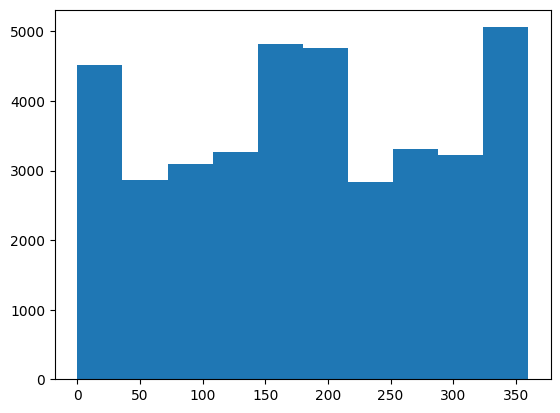

In [94]:
plt.hist(all_saccade_collection.overall_angle_deg)

(5, 39)
Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\saccade_amplitude_averaged_histogram_angle_2025_08_25_00_50_05


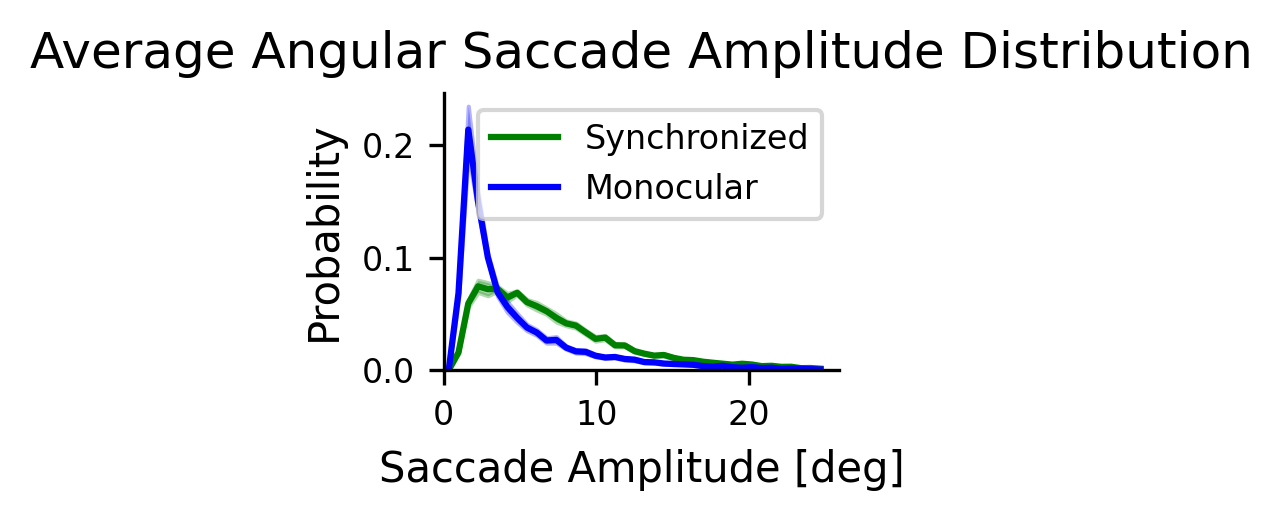

In [33]:
# overall saccade magnitude histogram
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
import datetime
import os
import pickle

def plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2.5, 1.7), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the average angular saccade amplitude likelihood histogram across animals,
    showing only the outline (with SEM shading) of the distributions.

    For each saccade event, the angular amplitude is computed as:

        angular_amplitude [deg] = sqrt( (angle_dx)^2 + (angle_dy)^2 )

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synced saccade data with an 'animal' column,
          and the angular delta columns 'angle_dx' and 'angle_dy'.
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synced saccade data with an 'animal' column,
          and the angular delta columns.
    - figure_size (tuple): Size of the figure for the plot.
    - export_path (str or pathlib.Path, optional): Path to save the plot and data.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    # Compute angular amplitude for each event (if not already computed)
    # We'll add a new column "angular_magnitude" computed from angle_dx and angle_dy.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    bin_centers = (bins[:-1] + bins[1:]) / 2  # For plotting the outline

    # Group by animals
    animals = synced_saccade_collection['animal'].unique()
    num_animals = len(animals)

    # Store normalized histograms for synced and non-synced data
    synced_likelihoods = []
    non_synced_likelihoods = []

    for animal in animals:
        # For each animal, filter the angular amplitudes
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Calculate histograms normalized to probabilities
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        synced_likelihoods.append(synced_hist)
        non_synced_likelihoods.append(non_synced_hist)

    # Convert to arrays for averaging
    synced_likelihoods = np.array(synced_likelihoods)
    non_synced_likelihoods = np.array(non_synced_likelihoods)
    print(np.shape(synced_likelihoods))

    # Calculate mean and SEM across animals
    synced_mean = synced_likelihoods.mean(axis=0)
    synced_sem = synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    non_synced_mean = non_synced_likelihoods.mean(axis=0)
    non_synced_sem = non_synced_likelihoods.std(axis=0) / np.sqrt(num_animals)

    # Plot averaged histograms
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Plot outline and SEM for synced (angle-based)
    ax.plot(bin_centers, synced_mean, color='green', linestyle='-', linewidth=1.5, label='Synchronized')
    ax.fill_between(bin_centers, synced_mean - synced_sem, synced_mean + synced_sem, color='green', alpha=0.3)

    # Plot outline and SEM for non-synced (angle-based)
    ax.plot(bin_centers, non_synced_mean, color='blue', linestyle='-', linewidth=1.5, label='Monocular')
    ax.fill_between(bin_centers, non_synced_mean - non_synced_sem, non_synced_mean + non_synced_sem, color='blue', alpha=0.3)

    # Customize the plot
    ax.set_title('Average Angular Saccade Amplitude Distribution', fontsize=12)
    ax.set_xlabel('Saccade Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Probability', fontsize=10)
    ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)

    # Handle export
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_averaged_histogram_angle_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_averaged_histogram_angle.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "averaged_saccade_amplitude_angle_data.pkl")
        with open(data_file, 'wb') as f:
            pickle.dump({
                'synced_mean': synced_mean,
                'synced_sem': synced_sem,
                'non_synced_mean': non_synced_mean,
                'non_synced_sem': non_synced_sem,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")


    plt.show()
    print()

export_path = r"Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg"

plot_averaged_saccade_amplitude_distribution_angle(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(1.7, 1.2), export_path=export_path,
    bins=np.linspace(0,25,40))

Exported plot to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_08_25_01_15_horizontal_tuning_per_animal\2025_08_25_01_15_horizontal_tuning_per_animal.pdf
Exported data to Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning\2025_08_25_01_15_horizontal_tuning_per_animal\2025_08_25_01_15_saccade_angles_data.pkl


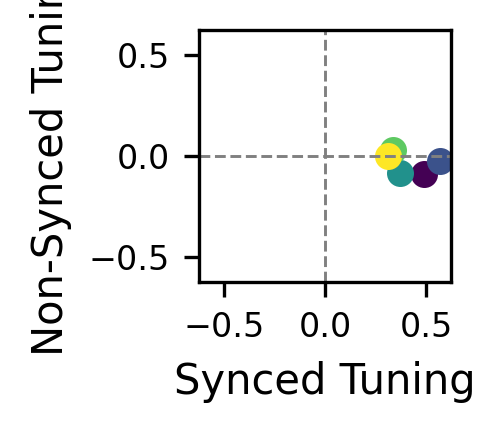

{'PV_106': (0.48915449313855697, -0.08888219343175652),
 'PV_143': (0.5684803001876173, -0.02656137832017219),
 'PV_62': (0.3726384364820847, -0.08596713021491786),
 'PV_126': (0.33529845246868084, 0.028689941237469707),
 'PV_57': (0.30952380952380953, 0.002385758854835718)}

In [43]:
import numpy as np
import matplotlib.pyplot as plt
def calculate_orientation_tuning(saccade_angles):
    """
    Calculates the orientation tuning statistic for a collection of saccade angles.

    Parameters:
        saccade_angles (array-like): List or array of saccade angles in degrees.

    Returns:
        float: Orientation tuning statistic.
    """
    # Convert angles to range [0, 360] if they aren't already
    saccade_angles = np.array(saccade_angles) % 360

    # Define horizontal saccade ranges
    horizontal_ranges = [
        (315, 360),  # 330° to 0°
        (0, 45),     # 0° to 30°
        (135, 225)   # 150° to 210°
    ]

    # Identify horizontal saccades
    is_horizontal = np.logical_or.reduce([
        (saccade_angles >= low) & (saccade_angles <= high)
        if low < high else
        (saccade_angles >= low) | (saccade_angles <= high)
        for low, high in horizontal_ranges
    ])

    # Calculate probabilities
    p_horizontal = np.sum(is_horizontal) / len(saccade_angles)
    p_vertical = 1 - p_horizontal  # Vertical saccades are the complement

    # Calculate orientation tuning
    tuning_statistic = (p_horizontal - p_vertical) / (p_horizontal + p_vertical)

    return tuning_statistic

# 'tuning' is not good - I need to use something that will be clear to someone without reading the text.. maybe saccade horizontal bias

def analyze_orientation_tuning(synced_df, non_synced_df, export_path=None):
    """
    Analyze orientation tuning for each unique animal in the given dataframes.

    Parameters:
        synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for synchronized saccades.
        non_synced_df (pd.DataFrame): DataFrame containing 'animal' and 'angle' columns for non-synchronized saccades.

    Returns:
        dict: Dictionary with animal IDs as keys and a tuple of (synced_tuning, non_synced_tuning) as values.
    """
    # Initialize dictionary to store results
    tuning_results = {}

    # Get unique animals
    unique_animals = synced_df['animal'].unique()

    for animal in unique_animals:
        # Filter data for the current animal
        synced_angles = synced_df.query('animal == @animal')['overall_angle_deg'].values
        non_synced_angles = non_synced_df.query('animal == @animal')['overall_angle_deg'].values

        # Calculate orientation tuning
        synced_tuning = calculate_orientation_tuning(synced_angles)
        non_synced_tuning = calculate_orientation_tuning(non_synced_angles)

        # Save to dictionary
        tuning_results[animal] = (synced_tuning, non_synced_tuning)

    # Plot results
    fig, ax = plt.subplots(figsize=(1.7, 1.7), dpi=300)

    synced_tuning_values = [v[0] for v in tuning_results.values()]
    non_synced_tuning_values = [v[1] for v in tuning_results.values()]
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_animals)))  # Generate unique colors

    for i, animal in enumerate(unique_animals):
        ax.scatter(
            synced_tuning_values[i],
            non_synced_tuning_values[i],
            color=colors[i],
            label=f"{animal}",
            s=30  # Marker size
        )

    # Formatting
    ax.set_xlabel("Synced Tuning", fontsize=10)
    ax.set_ylabel("Non-Synced Tuning", fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_aspect('equal')  # Ensure equal scaling
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.7)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.7)

    # Adjust axes limits to make sure x and y scales are identical
    all_values = synced_tuning_values + non_synced_tuning_values
    axis_limit = max(abs(min(all_values)), abs(max(all_values))) * 1.1
    ax.set_xlim(-axis_limit, axis_limit)
    ax.set_ylim(-axis_limit, axis_limit)

    # Move legend outside the plot
    #ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.05, 0.5), borderaxespad=0)

    plt.tight_layout()
    if export_path:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M")
        export_dir = pathlib.Path(export_path) / f'{timestamp}_horizontal_tuning_per_animal'
        export_dir.mkdir(parents=True, exist_ok=True)

        # Save PDF
        export_file_pdf = export_dir / f'{timestamp}_horizontal_tuning_per_animal.pdf'
        plt.savefig(export_file_pdf, format='pdf')
        print(f"Exported plot to {export_file_pdf}")

        # Save Pickle
        export_file_pkl = export_dir / f'{timestamp}_saccade_angles_data.pkl'
        with open(export_file_pkl, 'wb') as pkl_file:
            pickle.dump(saccade_collection, pkl_file)
        print(f"Exported data to {export_file_pkl}")
    plt.show()

    return tuning_results

export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\horizontal_tuning'
analyze_orientation_tuning(synced_saccade_collection,non_synced_saccade_collection,export_path=export_path)

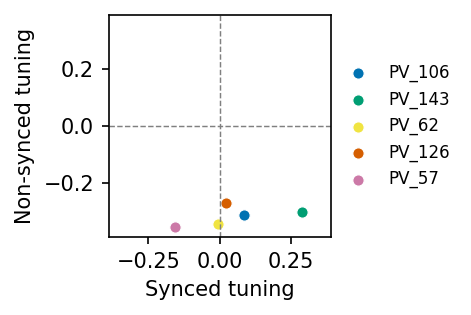

In [19]:
# Example: your global per-animal colors (use your real hexes)
GLOBAL_COLORS = {
'PV_106': '#0072B2',
'PV_126': '#D55E00',
'PV_143': '#009E73',
'PV_57': '#CC79A7',
'PV_62': '#F0E442'
}



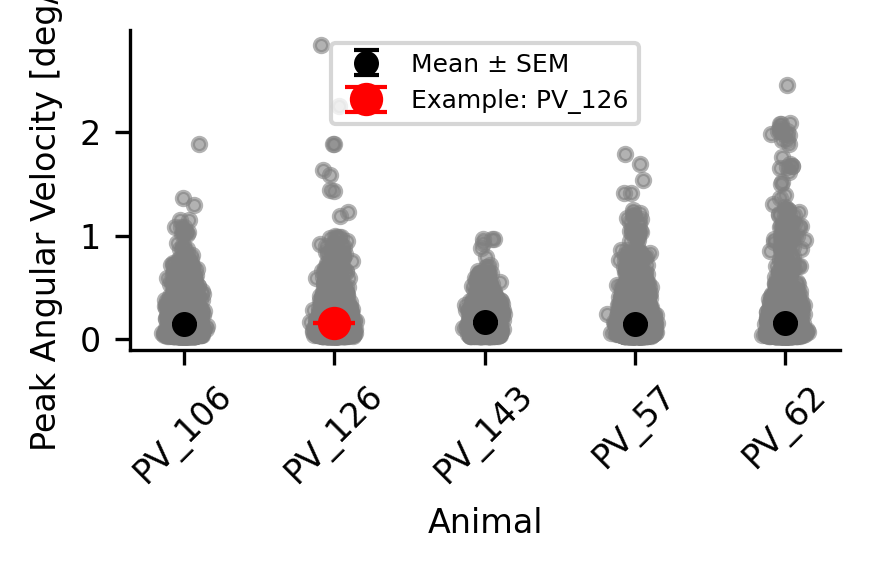

In [39]:
def plot_peak_velocity_scatter(
    saccade_collection, sampling_rate=60, example_animal=None,
    export_path=None, fig_size=(3,2), set_ylim=None
):
    """
    Creates a scatter plot of peak angular velocities (converted from deg/frame to deg/ms)
    for each animal in the saccade collection.

    For each animal, it:
      - Computes the peak velocity from each speed profile in 'speed_profile_angular'
      - Converts the value from deg/frame to deg/ms using the provided sampling_rate
      - Computes the mean peak velocity and its standard error (SEM)

    The function then plots:
      - All individual peak values as semi-transparent grey dots (with slight x-axis jitter)
      - The mean peak velocity for each animal with vertical error bars (SEM)
      - Optionally highlights a provided example animal in red.

    Parameters:
      - saccade_collection: DataFrame with at least the following columns:
          'animal' and 'speed_profile_angular' (a list/array of angular speed values in deg/frame)
      - sampling_rate: Sampling rate in Hz (default 60 Hz).
      - example_animal: Optional string specifying an animal to highlight.
      - export_path: Optional directory path to export the plot as a PDF.
      - fig_size: Tuple defining the figure size.
      - set_ylim: Optional y-axis limits.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import datetime, os

    # Calculate frame duration in ms (used to convert deg/frame to deg/ms)
    frame_duration = 1000 / sampling_rate

    # Get sorted unique animal names
    animals = sorted(saccade_collection['animal'].dropna().unique())

    # Prepare dictionaries to store peak values, means and SEMs for each animal
    all_peak_values = {}
    peak_means = []
    peak_stderr = []

    # Loop over each animal
    for animal in animals:
        # Get the group's data
        group = saccade_collection[saccade_collection['animal'] == animal]
        peaks = []

        # Iterate over each row (saccade) in the group
        for _, row in group.iterrows():
            profile = row['speed_profile_angular']
            # Skip if the profile is missing or empty
            if profile is None or (hasattr(profile, '__len__') and len(profile) == 0):
                continue
            # Ensure the profile is a NumPy array
            profile = np.array(profile)
            # Compute the peak velocity in deg/ms: max(angular speed) / (ms/frame)
            peak = np.max(profile) / frame_duration
            peaks.append(peak)

        # Compute mean and standard error if any peaks were found
        if len(peaks) > 0:
            mean_peak = np.mean(peaks)
            std_peak = np.std(peaks)
            stderr_peak = std_peak / np.sqrt(len(peaks))
        else:
            mean_peak = np.nan
            stderr_peak = np.nan

        all_peak_values[animal] = peaks
        peak_means.append(mean_peak)
        peak_stderr.append(stderr_peak)

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)
    x_positions = np.arange(len(animals))

    # Plot individual peak velocity values with a slight horizontal jitter for clarity.
    for i, animal in enumerate(animals):
        points = all_peak_values[animal]
        if len(points) > 0:
            # Add small jitter to spread points out
            jitter = np.random.normal(0, 0.04, size=len(points))
            ax.scatter(np.full(len(points), x_positions[i]) + jitter, points,
                       color='grey', alpha=0.6, s=10)

    # Plot mean peak velocity with SEM error bars
    ax.errorbar(x_positions, peak_means, yerr=peak_stderr, fmt='o',
                color='black', capsize=3, markersize=5, label='Mean ± SEM')

    # Optionally highlight the example animal in a different color
    if example_animal is not None and example_animal in animals:
        idx = animals.index(example_animal)
        ax.errorbar(x_positions[idx], peak_means[idx], yerr=peak_stderr[idx],
                    fmt='o', color='red', capsize=5, markersize=7, label=f'Example: {example_animal}')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(animals, rotation=45, fontsize=8)
    ax.set_xlabel('Animal', fontsize=8)
    ax.set_ylabel('Peak Angular Velocity [deg/ms]', fontsize=8)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(fontsize=6)
    plt.tight_layout()

    # Export the plot if an export path is provided
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_scatter_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_scatter.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")

    plt.show()

plot_peak_velocity_scatter(all_saccade_collection,sampling_rate=60,example_animal="PV_126",export_path=None,fig_size=(3,2))

In [25]:
def plot_peak_velocity_vs_time(
    saccade_collection, sampling_rate=60, floor=None, ceiling=None,
    export_path=None, fig_size=(2.5,1.7), set_xlim=None, example_animal=None, set_ylim=None
):
    """
    Computes and plots the peak angular velocity (in deg/ms) for each saccade,
    grouped by time-to-peak (in ms) and by animal.

    For each saccade:
      - The peak velocity is computed as the maximum value in 'speed_profile_angular'
        (which is in deg/frame) converted to deg/ms using the formula:
            peak_velocity = max(speed_profile_angular) * (sampling_rate / 1000)

    Then the data is grouped by 'time_to_peak_v' (already in ms) and 'animal', so that
    each animal contributes one average peak velocity per time-to-peak value.

    The function creates a scatter plot where:
      - The x-axis is the time-to-peak (ms).
      - Each unique time value has as many points as the number of animals with data for that time.
      - A black error bar represents the mean ± SEM across animals for each time value.
      - Optionally, one animal can be highlighted in red.

    Parameters:
      - saccade_collection: DataFrame that must include:
            * 'time_to_peak_v': time-to-peak in ms.
            * 'speed_profile_angular': a list/array of angular speeds (in deg/frame).
            * 'animal': animal identifier.
      - sampling_rate: Sampling rate in Hz (default 60). Used to convert deg/frame to deg/ms.
      - floor: Minimum time-to-peak value (ms) to include.
      - ceiling: Maximum time-to-peak value (ms) to include.
      - export_path: Optional directory to export the plot as a PDF.
      - fig_size: Figure size tuple.
      - set_xlim: Optional x-axis limits.
      - example_animal: Optional string specifying an animal to highlight.
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import datetime, os

    # Filter the dataframe for rows with valid time-to-peak and speed profile
    df = saccade_collection.dropna(subset=['time_to_peak_v', 'speed_profile_angular']).copy()

    # Apply floor and ceiling filters if provided (time-to-peak is in ms)
    if floor is not None:
        df = df[df['time_to_peak_v'] >= floor]
    if ceiling is not None:
        df = df[df['time_to_peak_v'] <= ceiling]

    # Compute the peak velocity for each saccade.
    # Convert from deg/frame to deg/ms by multiplying with (sampling_rate / 1000)
    def compute_peak(row):
        profile = np.array(row['speed_profile_angular'])
        return np.max(profile) * (sampling_rate / 1000)

    df['peak_velocity'] = df.apply(compute_peak, axis=1)

    # Group by time-to-peak and animal, so that each animal contributes one (average) peak value per time value.
    grouped = df.groupby(['time_to_peak_v', 'animal'])['peak_velocity'].mean().reset_index()

    # For each unique time-to-peak, compute the overall mean and SEM across animals.
    summary = grouped.groupby('time_to_peak_v').agg(
        mean_peak=('peak_velocity', 'mean'),
        sem_peak=('peak_velocity', lambda x: np.std(x, ddof=1)/np.sqrt(len(x)) if len(x) > 1 else 0)
    ).reset_index()

    # Create the scatter plot with x-axis in ms.
    fig, ax = plt.subplots(figsize=fig_size, dpi=300)

    # Plot individual animal points (with slight jitter along the x-axis for clarity).
    for animal in grouped['animal'].unique():
        animal_data = grouped[grouped['animal'] == animal]
        jitter = np.random.normal(0, 0.5, size=len(animal_data))
        ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                   s=5, alpha=0.7, label=animal)

    # # Plot the overall mean ± SEM for each time-to-peak value.
    # ax.errorbar(summary['time_to_peak_v'], summary['mean_peak'], yerr=summary['sem_peak'],
    #             fmt='o', color='black', capsize=3, markersize=5, label='Mean ± SEM')
    #
    # Optionally, highlight a specific animal in red.
    if example_animal is not None:
        if example_animal in grouped['animal'].unique():
            animal_data = grouped[grouped['animal'] == example_animal]
            jitter = np.random.normal(0, 0.5, size=len(animal_data))
            ax.scatter(animal_data['time_to_peak_v'] + jitter, animal_data['peak_velocity'],
                       s=5, color='red', alpha=0.9, label=f'Example: {example_animal}')

    ax.set_xlabel('TTP [ms]', fontsize=8)
    ax.set_ylabel('Peak V [deg/ms]', fontsize=8)
    if set_xlim is not None:
        ax.set_xlim(set_xlim)
    ax.tick_params(axis='both', labelsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if set_ylim is not None:
        ax.set_ylim(set_ylim)

    plt.tight_layout()
    #ax.legend(fontsize=6)

    # Optionally export the plot as a PDF.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"peak_velocity_vs_time_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "peak_velocity_vs_time.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Exported plot to: {full_export_path}")

    plt.show()
export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\ttp_profiles\inset'
plot_peak_velocity_vs_time(all_saccade_collection.query('time_to_peak_v > 0 and time_to_peak_v < 67'), sampling_rate=60, floor=1, ceiling=86,
    export_path=export_path, fig_size=(1.2,1.5), set_xlim=None, example_animal=None)

UndefinedVariableError: name 'time_to_peak_v' is not defined

Exported plot and data to: Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal\saccade_amplitude_difference_all_animals_2025_08_25_01_06_32


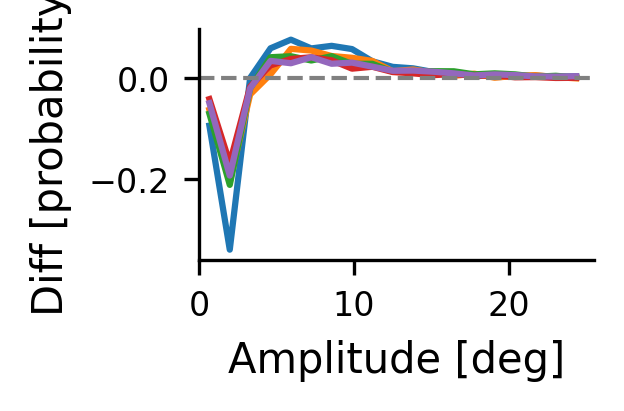

In [42]:
def plot_difference_saccade_amplitude_distribution_all_animals(
    synced_saccade_collection, non_synced_saccade_collection, figure_size=(2, 1.5), export_path=None,
    bins=np.linspace(0,5,40)
):
    """
    Plots the difference (synchronized minus monocular) of the normalized saccade amplitude histograms
    for each animal on a single plot. Each animal's trace is given a unique color.

    Parameters:
    - synced_saccade_collection (pd.DataFrame): DataFrame containing synchronized saccade data with an 'animal' column,
          and angular data (e.g. 'delta_phi' and 'delta_theta').
    - non_synced_saccade_collection (pd.DataFrame): DataFrame containing non-synchronized saccade data with an 'animal' column.
    - figure_size (tuple): Size of the figure.
    - export_path (str or pathlib.Path, optional): Directory where the plot and data will be saved.
    - bins (array-like): Bin edges for the histogram (default spans 0 to 5 deg).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime, os, pickle

    # Make sure both DataFrames have the computed angular amplitude column.
    for df in [synced_saccade_collection, non_synced_saccade_collection]:
        if 'magnitude_raw_angular' not in df.columns:
            df['magnitude_raw_angular'] = np.abs(df['delta_phi']) + np.abs(df['delta_theta'])

    # Compute bin centers for plotting.
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Retrieve unique animals.
    animals = synced_saccade_collection['animal'].unique()

    # Set up a single figure and axes.
    fig, ax = plt.subplots(figsize=figure_size, dpi=300)

    # Get the default color cycle from matplotlib.
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

    # Loop over each animal and plot its difference trace.
    for i, animal in enumerate(animals):
        # Filter data for the current animal.
        synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
        non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values

        # Compute histograms.
        synced_hist, _ = np.histogram(synced_data, bins=bins)
        non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)

        # Normalize the histograms.
        if synced_hist.sum() > 0:
            synced_hist = synced_hist / synced_hist.sum()
        if non_synced_hist.sum() > 0:
            non_synced_hist = non_synced_hist / non_synced_hist.sum()

        # Compute the difference: (synchronized minus monocular).
        diff_trace = synced_hist - non_synced_hist

        # Plot the trace using a color from the cycle.
        ax.plot(bin_centers, diff_trace, color=colors[i % len(colors)], linestyle='-',
                linewidth=1.5, label=f'{animal}')

    # Add a horizontal reference line at zero.
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)

    # Customize the plot.
    #ax.set_title('Difference in Saccade Amplitude Distribution\n(Synchronized - Monocular)', fontsize=12)
    ax.set_xlabel('Amplitude [deg]', fontsize=10)
    ax.set_ylabel('Diff [probability]', fontsize=10)
    #ax.legend(fontsize=8)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(left=0)

    # Optionally export the plot and data.
    if export_path is not None:
        timestamp = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
        full_export_path = os.path.join(export_path, f"saccade_amplitude_difference_all_animals_{timestamp}")
        os.makedirs(full_export_path, exist_ok=True)
        pdf_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals.pdf")
        fig.savefig(pdf_file, format='pdf', bbox_inches='tight', dpi=300)
        data_file = os.path.join(full_export_path, "saccade_amplitude_difference_all_animals_data.pkl")
        # Save each animal's difference trace keyed by animal name.
        data_dict = {}
        for animal in animals:
            synced_data = synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            non_synced_data = non_synced_saccade_collection.query("animal == @animal")['magnitude_raw_angular'].values
            synced_hist, _ = np.histogram(synced_data, bins=bins)
            non_synced_hist, _ = np.histogram(non_synced_data, bins=bins)
            if synced_hist.sum() > 0:
                synced_hist = synced_hist / synced_hist.sum()
            if non_synced_hist.sum() > 0:
                non_synced_hist = non_synced_hist / non_synced_hist.sum()
            data_dict[animal] = synced_hist - non_synced_hist
        with open(data_file, 'wb') as f:
            pickle.dump({
                'animal_diff_traces': data_dict,
                'bins': bins,
            }, f)
        print(f"Exported plot and data to: {full_export_path}")

    plt.show()


export_path = r'Z:\Nimrod\Paper_Figures\2024_Personalized_headstage_eye_tracking\Figure_3\materials\saccade_amp_hist_deg\diff_per_animal'
plot_difference_saccade_amplitude_distribution_all_animals(synced_saccade_collection,
                                                          non_synced_saccade_collection,
                                                          figure_size=(1.7, 1),
                                                          export_path=export_path,
                                                          bins=np.linspace(0,25,20))
